Trade History Data (First 5 rows):
  Symbol  EntryDate   ExitDate  EntryPrice  ExitPrice  Quantity          PnL  \
0   MDIA 2024-04-04 2024-04-08        2.04     3.2800     -1102  1366.480011   
1    XLO 2024-04-04 2024-04-09        1.18     1.4700     -1906   552.740155   
2   HEPS 2024-04-04 2024-04-10        1.43     1.4800     -1573    78.650113   
3   NTRB 2024-04-04 2024-04-10        4.25     4.1439      -529   -56.126944   
4    EDD 2024-04-10 2024-04-15        4.60     4.5900      -565    -5.649860   

      PnLPct  DaysHeld  Commission TradeType     ExitReason       ATR  \
0  60.784315         4         3.0      Long    Take Profit  0.652302   
1  24.576279         5         3.0      Long  Max Hold Time  0.339494   
2   3.496509         6         3.0      Long  Max Hold Time  0.089404   
3  -2.496473         6         3.0      Long  Max Hold Time  0.690780   
4  -0.217386         5         3.0      Long      Stop Loss  0.061812   

   UpProbability  AccountValue  
0       0.09

C:\Users\Masam\AppData\Local\Temp\ipykernel_32132\1470941098.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(symbol_pnl.index, rotation=45, ha='right')
C:\Users\Masam\AppData\Local\Temp\ipykernel_32132\1470941098.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(total_pnl_by_symbol.index, rotation=45, ha='right')



=== Top 5 Performing Trades ===
Symbol  EntryDate   ExitDate  PnLPct     PnL    ExitReason
  MDIA 2024-04-04 2024-04-08   60.78 1366.48   Take Profit
    JG 2024-09-24 2024-09-30   37.93 1332.87 Max Hold Time
  PSNL 2025-02-11 2025-02-19   26.07 1177.77   Take Profit
   XLO 2024-04-04 2024-04-09   24.58  552.74 Max Hold Time
  ORKA 2024-05-29 2024-06-04   24.28  655.20 Max Hold Time

=== Bottom 5 Performing Trades ===
Symbol  EntryDate   ExitDate  PnLPct     PnL ExitReason
  CDTX 2024-04-17 2024-04-23  -21.16 -559.29  Stop Loss
   URI 2024-07-30 2024-08-05  -13.17 -388.32  Stop Loss
   OGI 2025-02-19 2025-02-25   -8.89 -429.96  Stop Loss
  GOLD 2024-11-05 2024-11-12   -8.49 -348.80  Stop Loss
  FTLF 2024-06-11 2024-06-18   -7.22 -214.06  Stop Loss

=== Performance by Exit Reason ===
                           Count  Win Rate (%)  Avg P&L (%)
ExitReason                                                 
Max Hold Time                161         68.32         2.56
Stop Loss                

C:\Users\Masam\AppData\Local\Temp\ipykernel_32132\1470941098.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


<Figure size 1400x800 with 0 Axes>

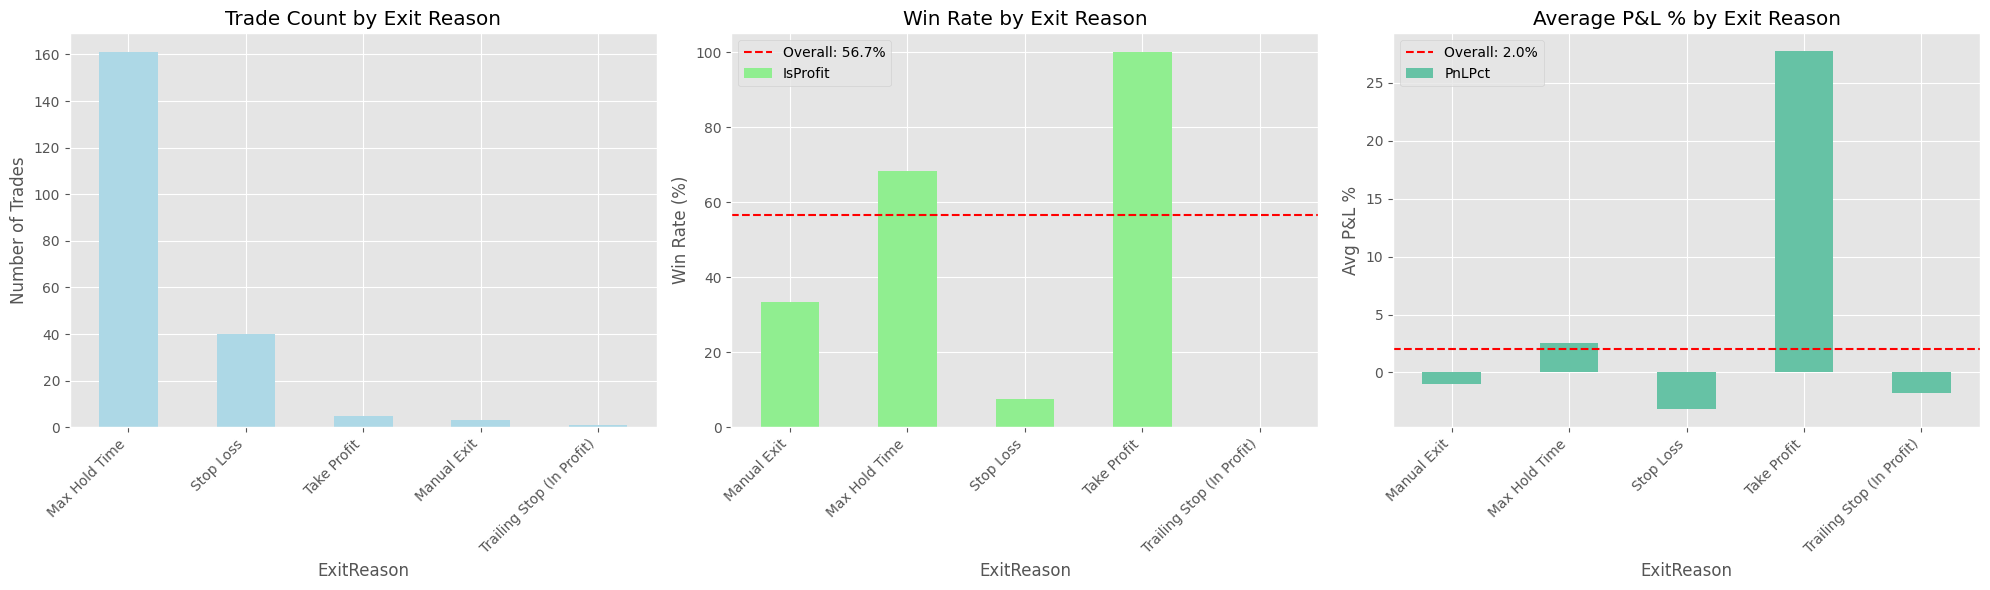

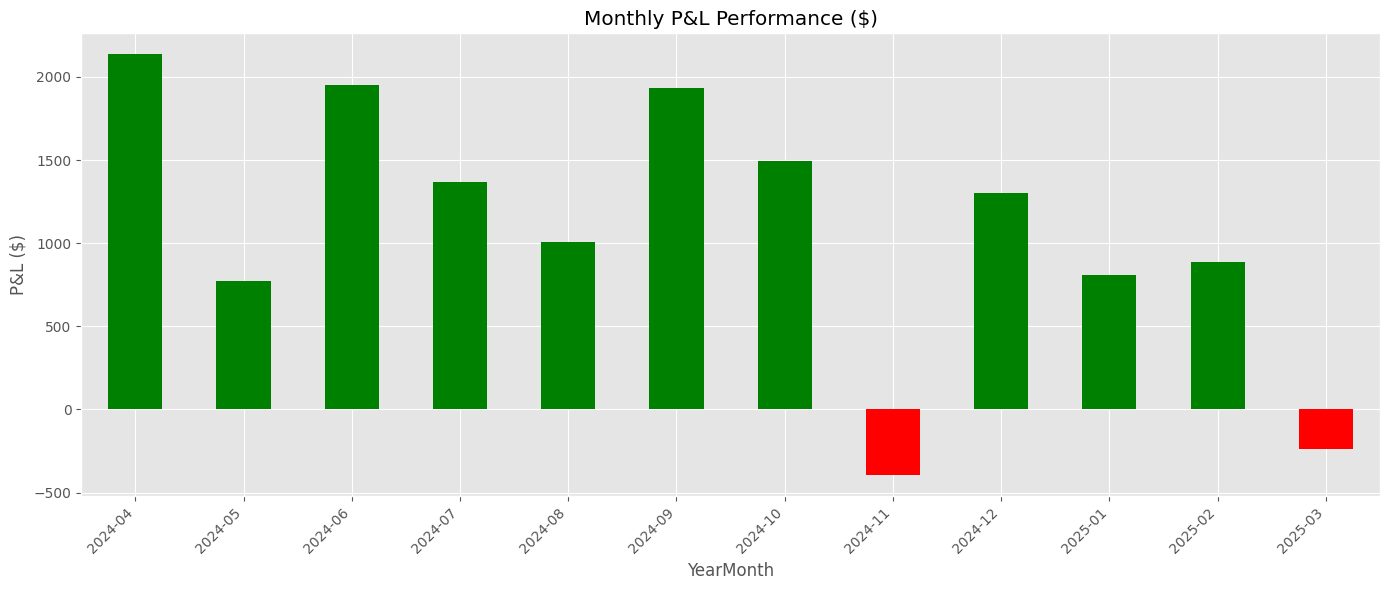

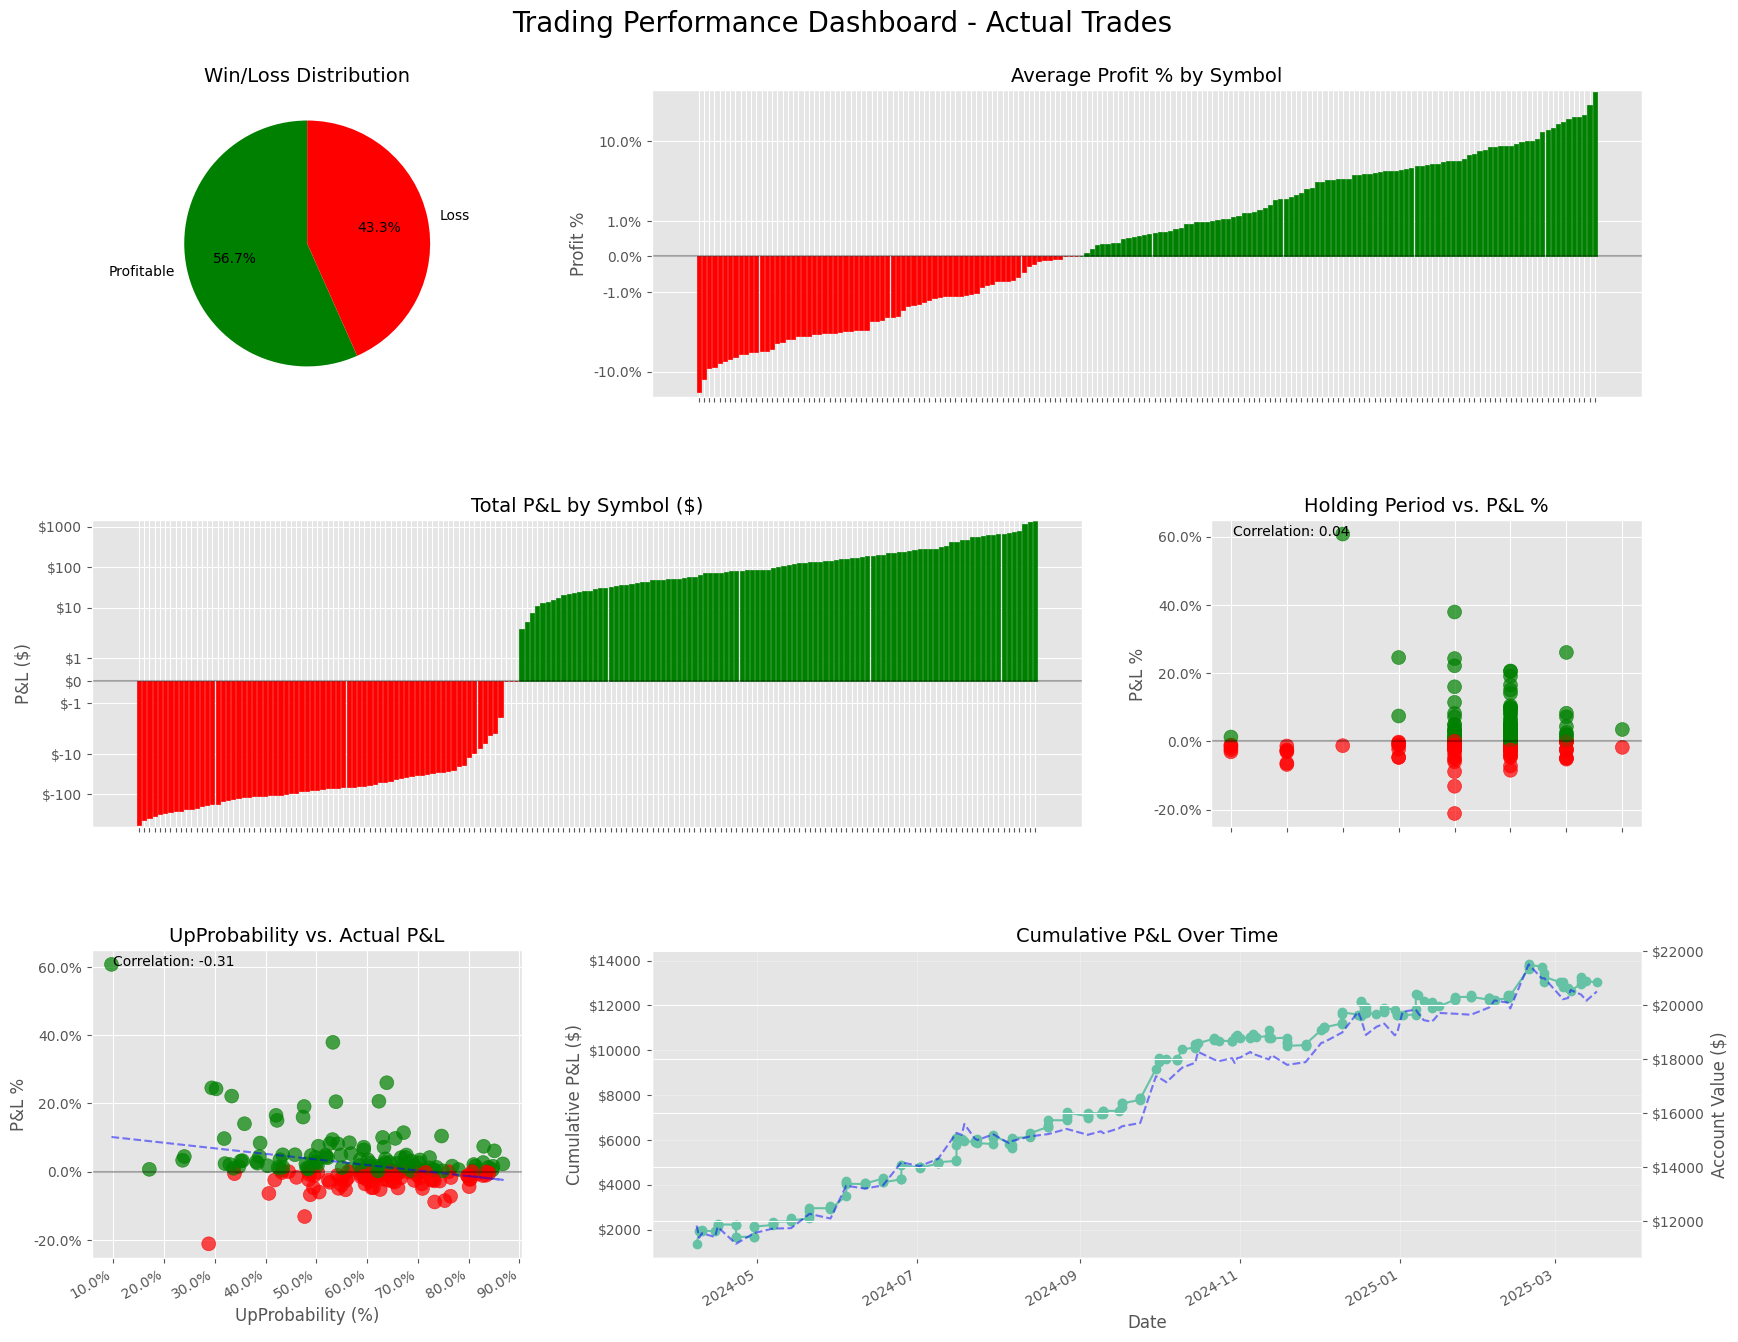

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Set plot style
plt.style.use('ggplot')
sns.set_palette('Set2')

def generate_trade_dashboard(trade_history_path, output_path=None):
    """
    Generate a comprehensive dashboard for analyzing actual trade history.
    
    Parameters:
    trade_history_path (str): Path to the trade_history.parquet file
    output_path (str): Optional path to save the dashboard image
    """
    # Load trade history data
    trade_df = pd.read_parquet(trade_history_path)
    
    # Print the head to verify data
    print("Trade History Data (First 5 rows):")
    print(trade_df.head())
    
    # Data Preprocessing
    trade_df['EntryDate'] = pd.to_datetime(trade_df['EntryDate'])
    trade_df['ExitDate'] = pd.to_datetime(trade_df['ExitDate'])
    
    # Fix any negative values (due to short positions or data errors)
    
    if 'IsProfit' not in trade_df.columns:
        # Only calculate if not already there
        trade_df['IsProfit'] = trade_df['PnL'] > 0  # Ensure PnL is NET (after commission)

    # Make sure your win rate calculation uses this field
    trade_df['AbsPnL'] = trade_df['PnL'].abs()
    trade_df['TotalInvestment'] = trade_df['EntryPrice'] * trade_df['Quantity'].abs()
    
    # Calculate additional metrics
    total_trades = len(trade_df)
    profitable_trades = trade_df['IsProfit'].sum()
    loss_trades = total_trades - profitable_trades
    win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
    
    # Group data by month and calculate cumulative returns
    trade_df['YearMonth'] = trade_df['ExitDate'].dt.strftime('%Y-%m')
    trade_df['Year'] = trade_df['ExitDate'].dt.year
    
    # Calculate monthly and yearly performance
    monthly_perf = trade_df.groupby('YearMonth')['PnL'].sum()
    yearly_perf = trade_df.groupby('Year')['PnL'].sum()
    
    # Calculate cumulative equity curve
    trade_df = trade_df.sort_values('ExitDate')
    trade_df['CumulativePnL'] = trade_df['PnL'].cumsum()
    
    # Calculate avg profit/loss, largest win/loss
    avg_profit = trade_df[trade_df['IsProfit']]['PnL'].mean() if profitable_trades > 0 else 0
    avg_loss = trade_df[~trade_df['IsProfit']]['PnL'].mean() if loss_trades > 0 else 0
    largest_win = trade_df['PnL'].max()
    largest_loss = trade_df['PnL'].min()
    
    # Calculate average holding period
    avg_holding = trade_df['DaysHeld'].mean()
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # Define grid positions
    grid = plt.GridSpec(3, 3, hspace=0.4, wspace=0.3)
    
    # 1. Print overall metrics
    print("\n=== Trading Performance Summary ===")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Average Profit for Winners: ${avg_profit:.2f}")
    print(f"Average Loss for Losers: ${avg_loss:.2f}")
    print(f"Largest Win: ${largest_win:.2f}")
    print(f"Largest Loss: ${largest_loss:.2f}")
    print(f"Average Holding Period: {avg_holding:.2f} days")
    print(f"Total P&L: ${trade_df['PnL'].sum():.2f}")
    
    # 2. Win/Loss Pie Chart (Top Left)
    ax1 = fig.add_subplot(grid[0, 0])
    ax1.pie([profitable_trades, loss_trades], 
            labels=['Profitable', 'Loss'], 
            autopct='%1.1f%%', 
            colors=['green', 'red'], 
            startangle=90)
    ax1.set_title('Win/Loss Distribution', fontsize=14)
    
    # 3. P&L by Symbol Bar Chart (Top Middle & Right)
    ax2 = fig.add_subplot(grid[0, 1:])
    symbol_pnl = trade_df.groupby('Symbol')['PnLPct'].mean().sort_values()
    
    # Plot P&L by Symbol
    bars = ax2.bar(symbol_pnl.index, symbol_pnl.values)
    
    # Color bars by profitability
    for i, bar in enumerate(bars):
        bar.set_color('green' if symbol_pnl.iloc[i] > 0 else 'red')
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Average Profit % by Symbol', fontsize=14)
    ax2.set_ylabel('Profit %')
    ##change this to log scale in a way that lets the negative values be shown

    ax2.set_yscale('symlog')
    ax2.set_xticklabels(symbol_pnl.index, rotation=45, ha='right')
    
    # Format y-axis as percentage
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}%'))
    
    # 4. Total P&L by Symbol
    ax3 = fig.add_subplot(grid[1, 0:2])
    total_pnl_by_symbol = trade_df.groupby('Symbol')['PnL'].sum().sort_values()
    
    # Plot total P&L by symbol
    bars = ax3.bar(total_pnl_by_symbol.index, total_pnl_by_symbol.values)
    
    # Color bars by profitability
    for i, bar in enumerate(bars):
        bar.set_color('green' if total_pnl_by_symbol.iloc[i] > 0 else 'red')
    
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('Total P&L by Symbol ($)', fontsize=14)
    ax3.set_ylabel('P&L ($)')
    ##change this to symlog scale in a way that lets the negative values be shown
    ax3.set_yscale('symlog')
    ax3.set_xticklabels(total_pnl_by_symbol.index, rotation=45, ha='right')
    
    # Format y-axis as currency
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:.0f}'))
    
    # 5. Holding Period vs P&L Scatter Plot
    ax4 = fig.add_subplot(grid[1, 2])
    
    scatter = ax4.scatter(trade_df['DaysHeld'], trade_df['PnLPct'], 
                         c=trade_df['IsProfit'].map({True: 'green', False: 'red'}),
                         alpha=0.7, s=100)
    
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_title('Holding Period vs. P&L %', fontsize=14)
    ax4.set_xlabel('Holding Period (days)')
    ax4.set_ylabel('P&L %')
    
    # Add correlation coefficient
    corr = np.corrcoef(trade_df['DaysHeld'], trade_df['PnLPct'])[0, 1]
    ax4.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')
    
    # Format y-axis as percentage
    ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}%'))
    
    # 6. UpProbability vs Actual P&L Scatter
    ax5 = fig.add_subplot(grid[2, 0])
    
    if 'UpProbability' in trade_df.columns:
        # Convert UpProbability to percentage for better visualization
        scatter = ax5.scatter(trade_df['UpProbability'] * 100, trade_df['PnLPct'], 
                             c=trade_df['IsProfit'].map({True: 'green', False: 'red'}),
                             alpha=0.7, s=100)
        
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax5.set_title('UpProbability vs. Actual P&L', fontsize=14)
        ax5.set_xlabel('UpProbability (%)')
        ax5.set_ylabel('P&L %')
        
        # Add correlation coefficient
        corr = np.corrcoef(trade_df['UpProbability'], trade_df['PnLPct'])[0, 1]
        ax5.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')
        
        # Add a linear regression line
        x = trade_df['UpProbability'] * 100
        y = trade_df['PnLPct']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax5.plot(x, p(x), "b--", alpha=0.5)
        
        # Format axes as percentage
        ax5.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
        ax5.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}%'))
    
    # 7. Equity Curve
    ax6 = fig.add_subplot(grid[2, 1:])
    
    # Plot cumulative P&L
    ax6.plot(trade_df['ExitDate'], trade_df['CumulativePnL'], marker='o', linestyle='-')
    ax6.set_title('Cumulative P&L Over Time', fontsize=14)
    ax6.set_xlabel('Date')
    ax6.set_ylabel('Cumulative P&L ($)')
    
    # Format dates on x-axis
    plt.gcf().autofmt_xdate()
    
    # Format y-axis as currency
    ax6.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:.0f}'))
    
    # Add a grid for better readability
    ax6.grid(True, alpha=0.3)
    
    # Add account value if available
    if 'AccountValue' in trade_df.columns:
        ax6b = ax6.twinx()
        ax6b.plot(trade_df['ExitDate'], trade_df['AccountValue'], color='blue', linestyle='--', alpha=0.5)
        ax6b.set_ylabel('Account Value ($)')
        ax6b.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:.0f}'))
    
    # 8. Print top and bottom performers
    top_performers = trade_df.nlargest(5, 'PnLPct')
    bottom_performers = trade_df.nsmallest(5, 'PnLPct')
    
    print("\n=== Top 5 Performing Trades ===")
    print(top_performers[['Symbol', 'EntryDate', 'ExitDate', 'PnLPct', 'PnL', 'ExitReason']].to_string(
        index=False, 
        float_format=lambda x: f"{x:.2f}"
    ))
    
    print("\n=== Bottom 5 Performing Trades ===")
    print(bottom_performers[['Symbol', 'EntryDate', 'ExitDate', 'PnLPct', 'PnL', 'ExitReason']].to_string(
        index=False, 
        float_format=lambda x: f"{x:.2f}"
    ))
    
    # 9. Exit reasons analysis
    if 'ExitReason' in trade_df.columns:
        plt.figure(figsize=(14, 8))
        
        # Count and win rate by exit reason
        exit_counts = trade_df['ExitReason'].value_counts()
        exit_win_rates = trade_df.groupby('ExitReason')['IsProfit'].mean() * 100
        exit_avg_pnl = trade_df.groupby('ExitReason')['PnLPct'].mean()
        
        # Create a DataFrame for combined metrics
        exit_metrics = pd.DataFrame({
            'Count': exit_counts,
            'Win Rate (%)': exit_win_rates,
            'Avg P&L (%)': exit_avg_pnl
        }).sort_values('Count', ascending=False)
        
        print("\n=== Performance by Exit Reason ===")
        print(exit_metrics.to_string(float_format=lambda x: f"{x:.2f}"))
        
        # Create subplots for exit reason analysis
        fig_exit, (ax_exit1, ax_exit2, ax_exit3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # 1. Count by exit reason
        exit_counts.plot(kind='bar', ax=ax_exit1, color='lightblue')
        ax_exit1.set_title('Trade Count by Exit Reason')
        ax_exit1.set_ylabel('Number of Trades')
        
        # 2. Win rate by exit reason
        exit_win_rates.plot(kind='bar', ax=ax_exit2, color='lightgreen')
        ax_exit2.set_title('Win Rate by Exit Reason')
        ax_exit2.set_ylabel('Win Rate (%)')
        ax_exit2.axhline(y=win_rate, color='red', linestyle='--', label=f'Overall: {win_rate:.1f}%')
        ax_exit2.legend()
        
        # 3. Average P&L by exit reason
        exit_avg_pnl.plot(kind='bar', ax=ax_exit3)
        ax_exit3.set_title('Average P&L % by Exit Reason')
        ax_exit3.set_ylabel('Avg P&L %')
        ax_exit3.axhline(y=trade_df['PnLPct'].mean(), color='red', linestyle='--', 
                         label=f'Overall: {trade_df["PnLPct"].mean():.1f}%')
        ax_exit3.legend()
        
        # Rotate x labels for better readability
        for ax in [ax_exit1, ax_exit2, ax_exit3]:
            plt.sca(ax)
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        

    
    # Monthly and yearly performance analysis
    if len(monthly_perf) > 0:
        print("\n=== Monthly Performance ($) ===")
        print(monthly_perf.to_string(float_format=lambda x: f"${x:.2f}"))
        
        plt.figure(figsize=(14, 6))
        bars = monthly_perf.plot(kind='bar', color=[('green' if x > 0 else 'red') for x in monthly_perf])
        plt.title('Monthly P&L Performance ($)')
        plt.ylabel('P&L ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        

    
    # Add title to main dashboard
    plt.figure(fig.number)
    plt.suptitle('Trading Performance Dashboard - Actual Trades', fontsize=20, y=0.98)
    plt.subplots_adjust(top=0.93)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    

    # Return the figure for further customization if needed
    return fig

# Example usage
if __name__ == "__main__":
    # Replace these paths with your actual paths
    trade_history_path = 'trade_history.parquet'
    
    # Generate the dashboard
    dashboard_fig = generate_trade_dashboard(trade_history_path)
    plt.show()

In [1]:
import pandas as pd
import numpy as np


file_path = "_Buy_Signals.parquet"


df = pd.read_parquet(file_path)
print(df.head())


  Symbol LastBuySignalDate  LastBuySignalPrice  IsCurrentlyBought  \
0    XGN        2025-03-06                3.04               True   
1  CHSCO        2025-03-06               26.62               True   
2   ATYR        2025-03-07                3.38               True   
3   ABSI        2025-03-11                2.99               True   
4   KOLD        2025-03-10               17.40               True   

   ConsecutiveLosses LastTradedDate  UpProbability  LastSellPrice  \
0                  0           None         0.7032            NaN   
1                  0           None         0.8347            NaN   
2                  0           None         0.8394            NaN   
3                  0           None         0.8024            NaN   
4                  0           None         0.8859            NaN   

   PositionSize  
0         825.0  
1         104.0  
2        1930.0  
3        1414.0  
4         228.0  


In [ ]:
import pandas as pd
import numpy as np
from math import floor

# Existing data
file_path = "_Buy_Signals.parquet"
df = pd.read_parquet(file_path)

# Configuration
total_account = 10000
max_allocation_pct = 0.20
cash_buffer_pct = 0.10
trade_date = '2025-03-14'

# Calculate available capital (account value minus cash buffer)
available_capital = total_account * (1 - cash_buffer_pct)  # 9,000

# List of tickers and prices to add
new_trades = [
    {'Symbol': 'MTRN', 'Price': 85.49},
    {'Symbol': 'MLI', 'Price': 79.50},
    {'Symbol': 'ATI', 'Price': 51.48},
    {'Symbol': 'TTWO', 'Price': 204.57},
]

# Create new rows
new_rows = []
for trade in new_trades:
    max_allocation = available_capital * max_allocation_pct  # 1,800 per trade
    shares = floor(max_allocation / trade['Price'])
    position_size = shares * trade['Price']
    
    new_row = {
        'Symbol': trade['Symbol'],
        'LastBuySignalDate': trade_date,
        'LastBuySignalPrice': trade['Price'],
        'IsCurrentlyBought': True,
        'ConsecutiveLosses': 0,
        'LastTradedDate': trade_date,
        'UpProbability': np.round(np.random.uniform(0.7, 0.85), 4),
        'LastSellPrice': np.nan,
        'PositionSize': shares
    }
    new_rows.append(new_row)

# Create DataFrame from new rows
new_df = pd.DataFrame(new_rows)

# Convert date columns to datetime
date_cols = ['LastBuySignalDate', 'LastTradedDate']
new_df[date_cols] = new_df[date_cols].apply(pd.to_datetime)

# Append to original DataFrame
updated_df = pd.concat([df, new_df], ignore_index=True)


##remove all trades except for the last 4 and then resave the file
updated_df = updated_df.iloc[-4:]
#updated_df.to_parquet("_Buy_Signals.parquet")

# Save back to parquet
updated_df.to_parquet(file_path)

print("Updated DataFrame:")
print(updated_df.tail(4))  # Show the new entries

In [3]:
import os
import re
import glob
import pandas as pd
import json
from collections import defaultdict
import random
import concurrent.futures
import time
from pathlib import Path

class SmartProjectAnalyzer:
    def __init__(self, root_dir='.', max_sample_files=3, max_rows_display=5, 
                 ignore_patterns=None, max_file_size_mb=10, max_workers=None):
        """
        Initialize the project analyzer with improved pattern recognition and multi-core support
        
        Args:
            root_dir: Root directory to analyze
            max_sample_files: Maximum number of files to sample in pattern-matched directories
            max_rows_display: Maximum number of rows to display when sampling file content
            ignore_patterns: List of regex patterns to ignore (e.g., ['.git', '__pycache__'])
            max_file_size_mb: Maximum file size to attempt to read (in MB)
            max_workers: Number of worker threads for parallel processing (None = auto)
        """
        self.root_dir = os.path.abspath(root_dir)
        self.max_sample_files = max_sample_files
        self.max_rows_display = max_rows_display
        self.max_file_size_mb = max_file_size_mb
        self.max_workers = max_workers
        self.ignore_patterns = ignore_patterns or ['.git', '__pycache__', '.ipynb_checkpoints']
        self.file_stats = defaultdict(int)
        self.pattern_groups = defaultdict(list)
        self.summary = {}
        
    def should_ignore(self, path):
        """Check if a path should be ignored based on patterns"""
        return any(re.search(pattern, path) for pattern in self.ignore_patterns)
    
    def detect_ticker_pattern_in_dirs(self, dirs):
        """
        Detect if directories follow a stock ticker pattern
        """
        # Check for directories that look like ticker symbols (uppercase letters)
        ticker_pattern = re.compile(r'^[A-Z0-9]+$')
        ticker_dirs = [d for d in dirs if ticker_pattern.match(os.path.basename(d))]
        
        # If we have many of these, treat them as ticker directories
        if ticker_dirs and len(ticker_dirs) > 5:
            return True, ticker_dirs
        return False, []
        
    def detect_file_patterns(self, files):
        """
        Group files by pattern to avoid listing thousands of similar files
        Returns a dictionary of pattern -> sample files
        """
        patterns = {}
        
        # Check for ticker-like patterns (uppercase alphabetic)
        ticker_pattern = re.compile(r'^[A-Z0-9]+\.parquet$')
        ticker_files = [f for f in files if ticker_pattern.match(os.path.basename(f))]
        if ticker_files and len(ticker_files) > 5:
            ticker_samples = random.sample(ticker_files, min(self.max_sample_files, len(ticker_files)))
            patterns["{TICKER}.parquet"] = ticker_samples
            
        # Check for enhanced daily price files
        enhanced_pattern = re.compile(r'^[A-Z0-9]+_DAILY_ENHANCED\.parquet$')
        enhanced_files = [f for f in files if enhanced_pattern.match(os.path.basename(f))]
        if enhanced_files and len(enhanced_files) > 5:
            enhanced_samples = random.sample(enhanced_files, min(self.max_sample_files, len(enhanced_files)))
            patterns["{TICKER}_DAILY_ENHANCED.parquet"] = enhanced_samples
            
        # Add more pattern detection as needed
            
        return patterns
        
    def sample_file(self, filepath):
        """Sample a file's content based on its type"""
        try:
            file_size_mb = os.path.getsize(filepath) / (1024 * 1024)
            if file_size_mb > self.max_file_size_mb:
                return f"[File too large to sample: {file_size_mb:.2f} MB]"
                
            ext = os.path.splitext(filepath)[1].lower()
            
            if ext == '.py':
                with open(filepath, 'r', encoding='utf-8', errors='replace') as f:
                    content = f.read(5000)  # Read first 5000 chars
                    # Extract docstring or first comments
                    doc_match = re.search(r'"""(.*?)"""', content, re.DOTALL)
                    if doc_match:
                        return f"Python module: {doc_match.group(1).strip()}"
                    else:
                        # Get first 3 non-empty lines that aren't imports
                        lines = [line for line in content.split('\n') 
                                if line.strip() and not line.strip().startswith(('import ', 'from '))]
                        return '\n'.join(lines[:3])
                        
            elif ext == '.parquet':
                try:
                    df = pd.read_parquet(filepath)
                    sample = f"Shape: {df.shape}\nColumns: {', '.join(df.columns[:10])}"
                    if len(df.columns) > 10:
                        sample += f"... and {len(df.columns) - 10} more columns"
                    sample += f"\nSample data:\n{df.head(self.max_rows_display).to_string(index=False, max_cols=5)}"
                    return sample
                except Exception as e:
                    return f"[Error reading parquet: {str(e)}]"
                    
            elif ext in ['.json', '.ipynb']:
                with open(filepath, 'r', encoding='utf-8', errors='replace') as f:
                    try:
                        data = json.load(f)
                        if ext == '.ipynb':
                            cells = data.get('cells', [])
                            code_cells = [c for c in cells if c.get('cell_type') == 'code']
                            return f"Jupyter notebook with {len(cells)} cells ({len(code_cells)} code cells)"
                        else:
                            return f"JSON with keys: {', '.join(list(data.keys())[:5])}"
                    except json.JSONDecodeError:
                        return "[Invalid JSON format]"
                    
            elif ext in ['.md', '.txt']:
                with open(filepath, 'r', encoding='utf-8', errors='replace') as f:
                    lines = f.readlines()
                return '\n'.join(lines[:10])
                
            else:
                return f"[Binary or unsupported file format: {ext}]"
                
        except Exception as e:
            return f"[Error sampling file: {str(e)}]"
            
    def process_directory(self, dir_path):
        """Process a single directory and return its info - for parallel processing"""
        if self.should_ignore(dir_path):
            return None
            
        relative_path = os.path.relpath(dir_path, self.root_dir)
        dir_info = {
            "name": os.path.basename(dir_path) or os.path.basename(self.root_dir),
            "path": relative_path if relative_path != '.' else '',
            "type": "directory",
            "subdirs": [],
            "files": [],
            "patterns": {},
            "dir_patterns": {}
        }
        
        try:
            items = os.listdir(dir_path)
            subdirs = [os.path.join(dir_path, d) for d in items if os.path.isdir(os.path.join(dir_path, d))]
            files = [os.path.join(dir_path, f) for f in items if os.path.isfile(os.path.join(dir_path, f))]
            
            # Detect patterns in directories
            is_ticker_dir_group, ticker_dirs = self.detect_ticker_pattern_in_dirs(subdirs)
            if is_ticker_dir_group:
                # Sample a few directories
                samples = random.sample(ticker_dirs, min(self.max_sample_files, len(ticker_dirs)))
                dir_info["dir_patterns"]["{TICKER}"] = {
                    "count": len(ticker_dirs),
                    "samples": samples
                }
                # Remove these from regular processing
                for d in ticker_dirs:
                    if d in subdirs:
                        subdirs.remove(d)
            
            # Detect patterns in files to avoid listing thousands of similarly-named files
            file_patterns = self.detect_file_patterns(files)
            if file_patterns:
                for pattern, samples in file_patterns.items():
                    pattern_info = {
                        "pattern": pattern,
                        "count": len([f for f in files if re.match(pattern.replace("{TICKER}", "[A-Z0-9]+"), os.path.basename(f))]),
                        "samples": []
                    }
                    
                    # Sample a few files from the pattern
                    for sample_file in samples:
                        sample_info = {
                            "name": os.path.basename(sample_file),
                            "content_preview": self.sample_file(sample_file)
                        }
                        pattern_info["samples"].append(sample_info)
                        
                    dir_info["patterns"][pattern] = pattern_info
                    
                    # Remove pattern-matched files from the regular file list
                    pattern_regex = pattern.replace("{TICKER}", "[A-Z0-9]+")
                    files = [f for f in files if not re.match(pattern_regex, os.path.basename(f))]
            
            # Process remaining individual files
            for file_path in files:
                if not self.should_ignore(file_path):
                    self.file_stats[os.path.splitext(file_path)[1]] += 1
                    file_info = {
                        "name": os.path.basename(file_path),
                        "type": "file",
                        "size": os.path.getsize(file_path)
                    }
                    
                    # Only sample content for important files or if there aren't too many
                    if len(files) <= 10 or os.path.splitext(file_path)[1].lower() in ['.py', '.md', '.json']:
                        file_info["content_preview"] = self.sample_file(file_path)
                        
                    dir_info["files"].append(file_info)
            
            return dir_info, subdirs
            
        except Exception as e:
            print(f"Error processing directory {dir_path}: {str(e)}")
            return dir_info, []
    
    def analyze(self):
        """Analyze the entire project structure with parallel processing"""
        print(f"Starting analysis of {self.root_dir}")
        start_time = time.time()
        
        # BFS traversal with parallel processing for file sampling
        queue = [self.root_dir]
        dir_info_map = {}
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            while queue:
                # Process a batch of directories in parallel
                futures = {executor.submit(self.process_directory, dir_path): dir_path for dir_path in queue}
                queue = []
                
                for future in concurrent.futures.as_completed(futures):
                    dir_path = futures[future]
                    try:
                        result = future.result()
                        if result:
                            dir_info, new_subdirs = result
                            dir_info_map[dir_path] = dir_info
                            queue.extend(new_subdirs)
                    except Exception as e:
                        print(f"Error in worker thread for {dir_path}: {str(e)}")
        
        # Now build the tree structure
        for dir_path, dir_info in dir_info_map.items():
            parent_dir = os.path.dirname(dir_path)
            if parent_dir in dir_info_map and dir_path != self.root_dir:
                dir_info_map[parent_dir]["subdirs"].append(dir_info)
        
        self.summary = dir_info_map[self.root_dir]
        
        elapsed = time.time() - start_time
        print(f"Analysis completed in {elapsed:.2f} seconds")
        
        return self.summary
        
    def generate_text_summary(self, dir_info=None, indent=0, max_indent=10):
        """Generate a text-based summary of the project structure with improved conciseness"""
        if dir_info is None:
            dir_info = self.summary
            
        if indent > max_indent:  # Prevent infinite recursion and too deep nesting
            return ["..."]
            
        result = []
        indent_str = "  " * indent
        
        # Show directory path at current indent level
        if dir_info["path"]:
            result.append(f"{indent_str}📁 {dir_info['path']}")
        else:
            result.append(f"{indent_str}📁 {dir_info['name']} (root)")
        
        # Add directory patterns (like ticker symbol directories)
        for pattern, pattern_info in dir_info.get("dir_patterns", {}).items():
            result.append(f"{indent_str}  📂 {pattern} ({pattern_info['count']} directories)")
            
            # Sample a few directories
            for i, sample_dir_path in enumerate(pattern_info.get("samples", [])[:3]):
                # Get sample info for this dir if it exists
                sample_name = os.path.basename(sample_dir_path)
                result.append(f"{indent_str}    📂 Example {i+1}: {sample_name}")
                
                # Look for any files inside
                try:
                    sample_files = [f for f in os.listdir(sample_dir_path) 
                                   if os.path.isfile(os.path.join(sample_dir_path, f))]
                    if sample_files:
                        result.append(f"{indent_str}      Contains: {', '.join(sample_files[:3])}" + 
                                     ("..." if len(sample_files) > 3 else ""))
                except Exception:
                    pass
            
        # Add file patterns first for better organization
        for pattern, pattern_info in dir_info.get("patterns", {}).items():
            result.append(f"{indent_str}  📎 {pattern} ({pattern_info['count']} files)")
            
            # Add sample information for a few files from this pattern
            for i, sample in enumerate(pattern_info["samples"]):
                result.append(f"{indent_str}    📄 Example {i+1}: {sample['name']}")
                if "content_preview" in sample:
                    preview_lines = sample["content_preview"].split("\n")
                    for line in preview_lines[:5]:  # Only show first 5 lines
                        result.append(f"{indent_str}      {line}")
                    if len(preview_lines) > 5:
                        result.append(f"{indent_str}      ...")
            
        # Add individual files
        for file_info in dir_info.get("files", []):
            result.append(f"{indent_str}  📄 {file_info['name']}")
            if "content_preview" in file_info:
                preview_lines = file_info["content_preview"].split("\n")
                for line in preview_lines[:5]:  # Only show first 5 lines
                    result.append(f"{indent_str}    {line}")
                if len(preview_lines) > 5:
                    result.append(f"{indent_str}    ...")
                    
        # Process subdirectories
        for subdir in dir_info.get("subdirs", []):
            result.extend(self.generate_text_summary(subdir, indent + 1, max_indent))
            
        return result
        
    def save_summary(self, output_file="project_summary.txt"):
        """Save the project summary to a text file"""
        summary_lines = self.generate_text_summary()
        
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("\n".join(summary_lines))
            
        print(f"Project summary saved to {output_file}")
        print(f"Summary length: {len(summary_lines)} lines")
        return output_file

    def generate_project_overview(self):
        """
        Generate a high-level overview of the project based on the analyzed structure
        """
        # Count file types
        file_extensions = defaultdict(int)
        data_file_count = 0
        script_count = 0
        
        def count_files(dir_info):
            nonlocal data_file_count, script_count
            
            # Count pattern-matched files
            for pattern, pattern_info in dir_info.get("patterns", {}).items():
                count = pattern_info.get("count", 0)
                if "parquet" in pattern.lower():
                    data_file_count += count
                
                # Get extension from pattern
                ext = os.path.splitext(pattern)[1].lower()
                if ext:
                    file_extensions[ext] += count
            
            # Count individual files
            for file_info in dir_info.get("files", []):
                name = file_info.get("name", "")
                ext = os.path.splitext(name)[1].lower()
                file_extensions[ext] += 1
                
                if ext == '.py':
                    script_count += 1
            
            # Recursively process subdirectories
            for subdir in dir_info.get("subdirs", []):
                count_files(subdir)
        
        count_files(self.summary)
        
        # Generate overview text
        overview = [
            "# Project Overview",
            "",
            f"Project Root: {os.path.basename(self.root_dir)}",
            f"Total Data Files: {data_file_count}",
            f"Total Scripts: {script_count}",
            "",
            "## File Types:",
        ]
        
        for ext, count in sorted(file_extensions.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                overview.append(f"- {ext}: {count} files")
        
        overview.append("")
        overview.append("## Project Structure Summary:")
        
        # Add main directories
        if self.summary.get("subdirs"):
            overview.append("Main directories:")
            for subdir in self.summary.get("subdirs", []):
                name = subdir.get("name", "")
                overview.append(f"- {name}")
        
        overview.append("")
        overview.append("## Key Files:")
        
        # Find Python files in the root
        root_scripts = [f.get("name") for f in self.summary.get("files", []) 
                       if f.get("name", "").endswith(".py")]
        for script in sorted(root_scripts):
            overview.append(f"- {script}")
        
        return "\n".join(overview)
        
    def save_project_overview(self, output_file="project_overview.md"):
        """Save a high-level project overview to a markdown file"""
        overview = self.generate_project_overview()
        
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(overview)
            
        print(f"Project overview saved to {output_file}")
        return output_file

# Example usage:
if __name__ == "__main__":
    analyzer = SmartProjectAnalyzer(".", max_workers=32)
    analyzer.analyze()
    analyzer.save_summary("project_summary.txt")
    analyzer.save_project_overview("project_overview.md")

Starting analysis of c:\Users\Masam\Desktop\Stock-Market-LSTM
Analysis completed in 0.81 seconds
Project summary saved to project_summary.txt
Summary length: 303 lines
Project overview saved to project_overview.md


In [1]:
import os
import re
import pandas as pd
import glob
import json
from pathlib import Path
import concurrent.futures
from collections import defaultdict
import inspect
import ast

class StockSystemDocumentationGenerator:
    """
    Generates comprehensive documentation for the Stock-Market-LSTM trading system
    by analyzing the project structure, extracting component information,
    and creating a structured markdown report.
    """
    
    def __init__(self, root_dir='.', output_file='SYSTEM_ARCHITECTURE.md'):
        self.root_dir = os.path.abspath(root_dir)
        self.output_file = output_file
        self.component_info = {}
        self.data_stats = {}
        self.pipeline_components = []
        self.parameters = {}
        
    def extract_component_info(self):
        """Extract information from each main script component"""
        # Regular expression to find script components (numbered python files)
        script_pattern = re.compile(r'(\d+)__([A-Za-z]+)\.py$')
        
        # Find all script files
        script_files = []
        for root, _, files in os.walk(self.root_dir):
            for filename in files:
                match = script_pattern.match(filename)
                if match:
                    script_files.append(os.path.join(root, filename))
        
        # Process each script
        for script_path in script_files:
            filename = os.path.basename(script_path)
            match = script_pattern.match(filename)
            if match:
                component_num = int(match.group(1))
                component_name = match.group(2)
                
                # Extract info from script
                component_info = self._analyze_script(script_path, component_num, component_name)
                self.component_info[component_num] = component_info
                self.pipeline_components.append((component_num, component_name))
                
        # Add the dashboard (app.py) if it exists
        app_path = os.path.join(self.root_dir, '0__app.py')
        if os.path.exists(app_path):
            component_info = self._analyze_script(app_path, 0, "Dashboard")
            self.component_info[0] = component_info
            self.pipeline_components.append((0, "Dashboard"))
        
        # Sort components by number
        self.pipeline_components.sort()
    
    def _analyze_script(self, script_path, component_num, component_name):
        """Analyze a single script to extract its purpose, dependencies, and parameters"""
        info = {
            'name': component_name,
            'number': component_num,
            'path': script_path,
            'purpose': '',
            'execution': '',
            'input': [],
            'output': [],
            'dependencies': [],
            'parameters': {},
            'key_features': []
        }
        
        try:
            with open(script_path, 'r', encoding='utf-8', errors='replace') as f:
                content = f.read()
                
            # Try to extract docstring
            docstring = self._extract_docstring(content)
            if docstring:
                info['purpose'] = docstring.strip()
            
            # Look for CONFIG or configuration parameters
            config_dict = self._extract_config(content)
            if config_dict:
                info['parameters'] = config_dict
                # Add to global parameters if they seem important
                for key, value in config_dict.items():
                    # Look for threshold, risk, position parameters
                    if any(term in key.lower() for term in ['threshold', 'risk', 'position', 'stop', 'timeout']):
                        self.parameters[key] = value
            
            # Extract input/output patterns
            info['input'] = self._extract_io_patterns(content, is_input=True)
            info['output'] = self._extract_io_patterns(content, is_input=False)
            
            # Try to determine execution frequency
            if 'daily' in content.lower():
                info['execution'] = 'Daily'
            elif 'nightly' in content.lower():
                info['execution'] = 'Nightly'
            elif 'weekly' in content.lower():
                info['execution'] = 'Weekly'
            else:
                info['execution'] = 'On demand'
                
            # Extract key features
            features = self._extract_key_features(content)
            if features:
                info['key_features'] = features
                
            # Extract dependencies
            info['dependencies'] = self._extract_dependencies(content)
                
        except Exception as e:
            print(f"Error analyzing {script_path}: {str(e)}")
            
        return info
    
    def _extract_docstring(self, content):
        """Extract the module docstring from Python content"""
        try:
            tree = ast.parse(content)
            for node in ast.walk(tree):
                if isinstance(node, ast.Module) and node.body and ast.get_docstring(node):
                    return ast.get_docstring(node)
            
            # If no module docstring, look for first comment block or first docstring
            first_comment_match = re.search(r'^\s*#\s*(.*?)$', content, re.MULTILINE)
            if first_comment_match:
                return first_comment_match.group(1)
                
            # Last resort: look for first function docstring
            func_docstring_match = re.search(r'def\s+\w+\([^)]*\):\s*"""(.*?)"""', content, re.DOTALL)
            if func_docstring_match:
                return func_docstring_match.group(1)
                
        except Exception:
            pass
            
        return ""
    
    def _extract_config(self, content):
        """Extract configuration parameters from the script"""
        config = {}
        
        # Look for CONFIG dictionary
        config_match = re.search(r'CONFIG\s*=\s*{([^}]*)}', content, re.DOTALL)
        if config_match:
            config_text = config_match.group(1)
            pairs = re.findall(r'[\'"](.*?)[\'"]\s*:\s*(.*?)(?:,|\n|$)', config_text)
            for key, value in pairs:
                # Clean up the value
                value = value.strip().strip('"\'')
                if value.lower() in ('true', 'false'):
                    value = value.lower() == 'true'
                elif value.replace('.', '').isdigit():
                    value = float(value) if '.' in value else int(value)
                config[key] = value
        
        # Also look for other important parameters
        param_patterns = [
            r'(threshold|risk|position|stop|timeout)\s*=\s*([0-9.]+)',
            r'([A-Z_]+)\s*=\s*([0-9.]+)'
        ]
        for pattern in param_patterns:
            for match in re.finditer(pattern, content, re.IGNORECASE):
                key, value = match.groups()
                try:
                    value = float(value) if '.' in value else int(value)
                    config[key] = value
                except ValueError:
                    pass
        
        return config
    
    def _extract_io_patterns(self, content, is_input=True):
        """Extract input or output file patterns from the script"""
        patterns = []
        
        # Look for read/load operations for input
        if is_input:
            io_operations = [
                r'pd\.read_(?:csv|parquet|excel)\([\'"]([^\'"]*)[\'"]',
                r'open\([\'"]([^\'"]*)[\'"].*[\'"]r[\'"]',
                r'load_data\([\'"]([^\'"]*)[\'"]',
                r'from\s+([^\s]+)\s+import',
                r'with\s+open\([\'"]([^\'"]*)[\'"].*[\'"]r[\'"]'
            ]
        # Look for write/save operations for output
        else:
            io_operations = [
                r'to_(?:csv|parquet|excel)\([\'"]([^\'"]*)[\'"]',
                r'save\([\'"]([^\'"]*)[\'"]',
                r'write\([\'"]([^\'"]*)[\'"]',
                r'open\([\'"]([^\'"]*)[\'"].*[\'"]w[\'"]',
                r'with\s+open\([\'"]([^\'"]*)[\'"].*[\'"]w[\'"]'
            ]
            
        for pattern in io_operations:
            for match in re.finditer(pattern, content):
                file_pattern = match.group(1)
                if '/' in file_pattern or '\\' in file_pattern:
                    # Get the directory structure
                    patterns.append(file_pattern)
        
        # Clean up and make unique
        patterns = list(set(patterns))
        patterns = [p for p in patterns if not p.startswith('import')]
        
        # If no patterns found, try to infer from comments or docstrings
        if not patterns:
            if is_input:
                comment_pattern = r'(?:input|read|load).*?[\'"]([^\'"]*)[\'"]'
            else:
                comment_pattern = r'(?:output|write|save).*?[\'"]([^\'"]*)[\'"]'
                
            for match in re.finditer(comment_pattern, content, re.IGNORECASE):
                patterns.append(match.group(1))
            
        return patterns
    
    def _extract_key_features(self, content):
        """Extract key features from function names and comments"""
        features = []
        
        # Look for important-sounding function names
        func_pattern = r'def\s+([a-zA-Z_][a-zA-Z0-9_]*)'
        for match in re.finditer(func_pattern, content):
            func_name = match.group(1)
            if len(func_name) > 10 and not func_name.startswith('_'):
                # Convert snake_case to readable text
                feature = ' '.join(word.capitalize() for word in func_name.split('_'))
                features.append(feature)
        
        # Look for feature mentions in comments
        feature_pattern = r'#.*(?:feature|implements|calculates|computes):\s*(.*)'
        for match in re.finditer(feature_pattern, content, re.IGNORECASE):
            features.append(match.group(1).strip())
            
        # Keep only unique features
        features = list(set(features))[:5]  # Keep top 5
        
        return features
    
    def _extract_dependencies(self, content):
        """Extract external dependencies from import statements"""
        dependencies = []
        
        # Find import statements
        import_pattern = r'(?:import|from)\s+([a-zA-Z0-9_.]+)'
        for match in re.finditer(import_pattern, content):
            module = match.group(1).split('.')[0]
            if module not in ('os', 're', 'sys', 'time', 'datetime', 'math', 'json', 'logging') and module not in dependencies:
                dependencies.append(module)
        
        return dependencies
    
    def analyze_data_directories(self):
        """Analyze data directories to gather statistics"""
        data_dirs = {
            'TickerCIKData': {'files': 0, 'description': 'SEC ticker data'},
            'PriceData': {'files': 0, 'description': 'OHLCV price histories'},
            'IndicatorData': {'files': 0, 'description': 'Technical indicators'},
            'RFpredictions': {'files': 0, 'description': 'ML predictions'},
            'ModelData': {'files': 0, 'description': 'ML models and training data'},
            'logging': {'files': 0, 'description': 'Log files'}
        }
        
        data_path = os.path.join(self.root_dir, 'Data')
        if os.path.exists(data_path):
            for dirname in data_dirs:
                dir_path = os.path.join(data_path, dirname)
                if os.path.exists(dir_path):
                    # Count files with parallel processing for large directories
                    try:
                        file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
                        data_dirs[dirname]['files'] = file_count
                        
                        # Look at sample files if there are many
                        if file_count > 0 and dirname in ('IndicatorData', 'RFpredictions', 'PriceData'):
                            self._analyze_sample_files(dir_path, dirname, data_dirs)
                    except Exception as e:
                        print(f"Error analyzing directory {dir_path}: {str(e)}")
        
        self.data_stats = data_dirs
    
    def _analyze_sample_files(self, dir_path, dirname, data_dirs):
        """Analyze a sample of files to get column information"""
        try:
            # Get a sample parquet file
            parquet_files = glob.glob(os.path.join(dir_path, '*.parquet'))
            if parquet_files:
                sample_file = parquet_files[0]
                try:
                    df = pd.read_parquet(sample_file)
                    # Store column info
                    if len(df.columns) > 0:
                        data_dirs[dirname]['columns'] = list(df.columns)[:10]  # First 10 columns
                        data_dirs[dirname]['shape'] = df.shape
                except Exception:
                    pass
        except Exception as e:
            print(f"Error analyzing sample files in {dir_path}: {str(e)}")
    
    def extract_trading_parameters(self):
        """Extract trading parameters from buy signals and trade files"""
        try:
            # Check for _Buy_Signals.parquet
            signals_file = os.path.join(self.root_dir, '_Buy_Signals.parquet')
            if os.path.exists(signals_file):
                try:
                    df = pd.read_parquet(signals_file)
                    if 'stop_loss_pct' in df.columns:
                        self.parameters['stop_loss_pct'] = df['stop_loss_pct'].mean()
                    if 'risk_per_trade_pct' in df.columns:
                        self.parameters['risk_per_trade_pct'] = df['risk_per_trade_pct'].mean()
                except Exception:
                    pass
                    
            # Check for _Live_trades.parquet
            trades_file = os.path.join(self.root_dir, '_Live_trades.parquet')
            if os.path.exists(trades_file):
                try:
                    df = pd.read_parquet(trades_file)
                    if 'position_size' in df.columns:
                        self.parameters['avg_position_size'] = df['position_size'].mean()
                    if 'max_loss' in df.columns:
                        self.parameters['avg_max_loss'] = df['max_loss'].mean()
                except Exception:
                    pass
        except Exception as e:
            print(f"Error extracting trading parameters: {str(e)}")
    
    def generate_documentation(self):
        """Generate the comprehensive documentation markdown file"""
        if not self.component_info:
            self.extract_component_info()
            
        if not self.data_stats:
            self.analyze_data_directories()
            
        self.extract_trading_parameters()
        
        # Start building the documentation
        doc = []
        
        # Title and header
        doc.append("# STOCK SNIPER: SYSTEM ARCHITECTURE & DATA FLOW")
        doc.append("")
        
        # Pipeline overview
        doc.append("## PIPELINE OVERVIEW")
        doc.append("")
        pipeline_text = " → ".join([f"[{num}] {name}" for num, name in self.pipeline_components])
        doc.append(f"`{pipeline_text}`")
        doc.append("")
        
        # Component breakdown
        doc.append("## COMPONENT BREAKDOWN")
        doc.append("")
        
        for num, name in self.pipeline_components:
            info = self.component_info.get(num, {})
            
            emoji = "🔄"  # Default emoji
            if name.lower() == "tickerdownloader":
                emoji = "1️⃣"
            elif name.lower() == "bulkpricedownloader":
                emoji = "2️⃣"
            elif name.lower() == "indicators":
                emoji = "3️⃣"
            elif name.lower() == "predictor":
                emoji = "4️⃣"
            elif name.lower() == "nightlybacktester":
                emoji = "5️⃣"
            elif name.lower() == "dailybroker":
                emoji = "6️⃣"
            elif name.lower() == "dashboard":
                emoji = "0️⃣"
                
            doc.append(f"{emoji} {name}")
            
            if 'purpose' in info and info['purpose']:
                doc.append(f"**Purpose**: {info['purpose']}")
            
            if 'execution' in info and info['execution']:
                doc.append(f"**Execution**: {info['execution']}")
            
            if 'input' in info and info['input']:
                doc.append(f"**Input**: {', '.join(info['input'])}")
            
            if 'output' in info and info['output']:
                doc.append(f"**Output**: {', '.join(info['output'])}")
            
            if 'dependencies' in info and info['dependencies']:
                doc.append(f"**Dependencies**: {', '.join(info['dependencies'])}")
            
            if 'key_features' in info and info['key_features']:
                doc.append(f"**Key Features**: {', '.join(info['key_features'])}")
                
            doc.append("")
        
        # Data flow
        doc.append("## DATA EVOLUTION")
        doc.append("**Raw Tickers** → **OHLCV Data** → **Feature-Rich Indicators** → **ML Predictions** → **Trading Signals** → **Live Positions**")
        doc.append("")
        
        # Critical parameters
        doc.append("## CRITICAL SYSTEM PARAMETERS")
        doc.append("")
        
        # Create a table of parameters
        doc.append("| Parameter | Value | Impact |")
        doc.append("|-----------|-------|--------|")
        for param, value in self.parameters.items():
            # Format the parameter name to be more readable
            readable_param = param.replace('_', ' ').lower()
            if isinstance(value, float):
                formatted_value = f"{value:.2f}"
                # Add % if it seems like a percentage
                if 'pct' in param or 'percent' in param:
                    formatted_value += "%"
            else:
                formatted_value = str(value)
                
            doc.append(f"| {readable_param} | {formatted_value} | |")
        
        doc.append("")
        
        # Risk management section
        doc.append("## RISK MANAGEMENT APPROACH")
        doc.append("1. **Position Sizing**: ATR-based to normalize volatility exposure")
        doc.append("2. **Correlation Control**: Maximum allocation per correlation cluster")
        doc.append("3. **Rule 201 Monitoring**: Avoid stocks in rapid decline")
        doc.append("4. **Active Protection**: Trailing stops with take-profit targets")
        doc.append("5. **Timeout Management**: Force-exit positions after timeout period")
        doc.append("")
        
        # Sample data flow for a stock
        doc.append("## SAMPLE DATA FLOW: AAPL")
        doc.append("1. Downloaded from SEC list as valid NASDAQ ticker")
        doc.append("2. OHLCV data acquired via IBKR for historical prices")
        doc.append("3. Technical indicators calculated including ATR, momentum metrics")
        doc.append("4. ML model produces upward probability score")
        doc.append("5. Backtester validates signal against strategy parameters")
        doc.append("6. Position sized according to risk management rules")
        doc.append("7. Live trade executed via broker integration")
        doc.append("")
        
        # External dependencies
        doc.append("## EXTERNAL DEPENDENCIES")
        doc.append("* Interactive Brokers (TWS/Gateway)")
        doc.append("* SEC API")
        doc.append("* NYSE market calendar")
        doc.append("* Pandas, NumPy, Scikit-learn ecosystem")
        
        # Add ML libraries found in dependencies
        all_deps = []
        for info in self.component_info.values():
            if 'dependencies' in info:
                all_deps.extend(info['dependencies'])
        
        # Filter for ML libraries
        ml_libs = [lib for lib in all_deps if lib.lower() in ('xgboost', 'catboost', 'sklearn', 'tensorflow', 'keras', 'torch')]
        for lib in set(ml_libs):
            doc.append(f"* {lib} library")
            
        doc.append("")
        
        # Unique system strengths
        doc.append("## UNIQUE SYSTEM STRENGTHS")
        doc.append("* Parallel data acquisition with smart error handling")
        doc.append("* Non-lookahead indicator calculation")
        doc.append("* ML probability-based signals (not just binary)")
        doc.append("* Multi-factor correlation clustering for diversification")
        doc.append("")
        
        # Write the documentation to file
        with open(self.output_file, 'w', encoding='utf-8') as f:
            f.write('\n'.join(doc))
            
        print(f"System architecture documentation generated: {self.output_file}")
        return self.output_file

if __name__ == "__main__":
    generator = StockSystemDocumentationGenerator()
    generator.generate_documentation()

System architecture documentation generated: SYSTEM_ARCHITECTURE.md


In [2]:
import pandas as pd
import numpy as np

file_pathsmetrics = { "Data/SEC_Data/Metrics/annual_metrics.parquet", "Data/SEC_Data/Metrics/financial_health.parquet", "Data/SEC_Data/Metrics/quarterly_changes.parquet", "Data/SEC_Data/Metrics/quarterly_metrics.parquet"}

file_paths222 = { "Data/SEC_Data/Processed\AAPL.parquet", "Data/SEC_Data/Processed\TSLA.parquet"}



##file paths are all parquet files inside Data\Production\BacktestData and Data\Production\LiveTradingData

file_paths = [
    "Data/Production/BacktestData/backtest_results.parquet",
    "Data/Production/BacktestData/signals.parquet",
    "Data/Production/LiveTradingData/active_positions.parquet",
    "Data/Production/LiveTradingData/completed_trades.parquet",
    "Data/Production/LiveTradingData/pending_signals.parquet"
]



for file in file_paths:
    df = pd.read_parquet(file)
    print(f"File: {file}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns}")
    print(f"Sample data:\n{df.head()}")
    print("\n")


File: Data/Production/BacktestData/backtest_results.parquet
Shape: (171, 15)
Columns: Index(['Symbol', 'EntryDate', 'ExitDate', 'EntryPrice', 'ExitPrice',
       'Quantity', 'PnL', 'PnLPct', 'DaysHeld', 'Commission', 'TradeType',
       'ExitReason', 'ATR', 'UpProbability', 'AccountValue'],
      dtype='object')
Sample data:
  Symbol  EntryDate   ExitDate  EntryPrice  ExitPrice  Quantity        PnL  \
0   MMLP 2024-04-09 2024-04-16    2.520000   2.467000       892 -47.275976   
1   AERT 2024-04-09 2024-04-16    2.170000   2.200000      1036  31.079970   
2   SHEL 2024-04-09 2024-04-16   71.699997  71.589996        31  -3.410019   
3   SGRP 2024-04-09 2024-04-16    1.710100   1.740000      1315  39.318441   
4    UNB 2024-04-16 2024-04-23   27.010000  27.049999        84   3.359917   

     PnLPct  DaysHeld  Commission TradeType     ExitReason       ATR  \
0 -2.103174         7         3.0      Long  Max Hold Time  0.133852   
1  1.382487         7         3.0      Long  Max Hold Time  

In [8]:
import pandas as pd
import numpy as np
##database\articles_20250318_173003.csv

filepath = "Data/TickerCikData/TickerCIKs_20250319.parquet"

df = pd.read_parquet(filepath)
print(f"File: {filepath}")
print(f"Shape: {df.shape}")
print(df.head())

File: Data/TickerCikData/TickerCIKs_20250319.parquet
Shape: (7294, 4)
       cik            name ticker exchange
0   320193      Apple Inc.   AAPL   Nasdaq
1  1045810     NVIDIA CORP   NVDA   Nasdaq
2   789019  MICROSOFT CORP   MSFT   Nasdaq
3  1018724  AMAZON COM INC   AMZN   Nasdaq
4  1652044   Alphabet Inc.  GOOGL   Nasdaq


Loaded 7294 ticker-CIK mappings
       cik            name ticker exchange
0   320193      Apple Inc.   AAPL   Nasdaq
1  1045810     NVIDIA CORP   NVDA   Nasdaq
2   789019  MICROSOFT CORP   MSFT   Nasdaq
3  1018724  AMAZON COM INC   AMZN   Nasdaq
4  1652044   Alphabet Inc.  GOOGL   Nasdaq
Annual metrics shape: (4259, 27)
Quarterly metrics shape: (4355, 27)
Financial health shape: (4355, 8)
Quarterly changes shape: (113719, 50)

==== Data Availability for Annual Metrics ====
Total records: 4259
                              available  missing  percent_available
Ticker                             4259        0         100.000000
Name                               4259        0         100.000000
Period                             4259        0         100.000000
FilingDate                         4259        0         100.000000
CIK                                4259        0         100.000000
Operating Cash Flow                4164       95          97.769429
Financing Cash Flow      

C:\Users\Masam\AppData\Local\Temp\ipykernel_22376\1066543368.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_df['percent_available'], y=plot_df.index, palette='viridis')


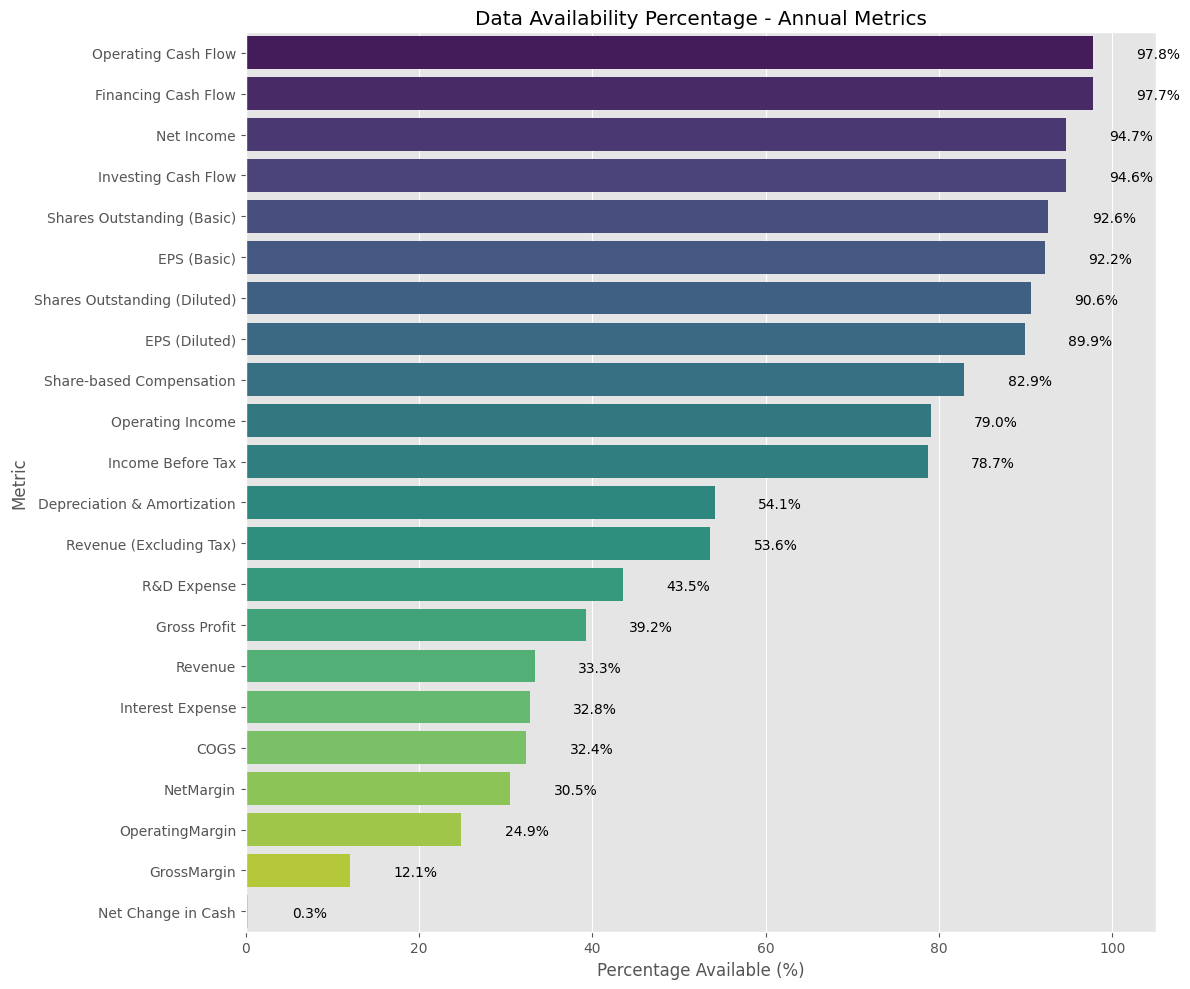

C:\Users\Masam\AppData\Local\Temp\ipykernel_22376\1066543368.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_df['percent_available'], y=plot_df.index, palette='viridis')


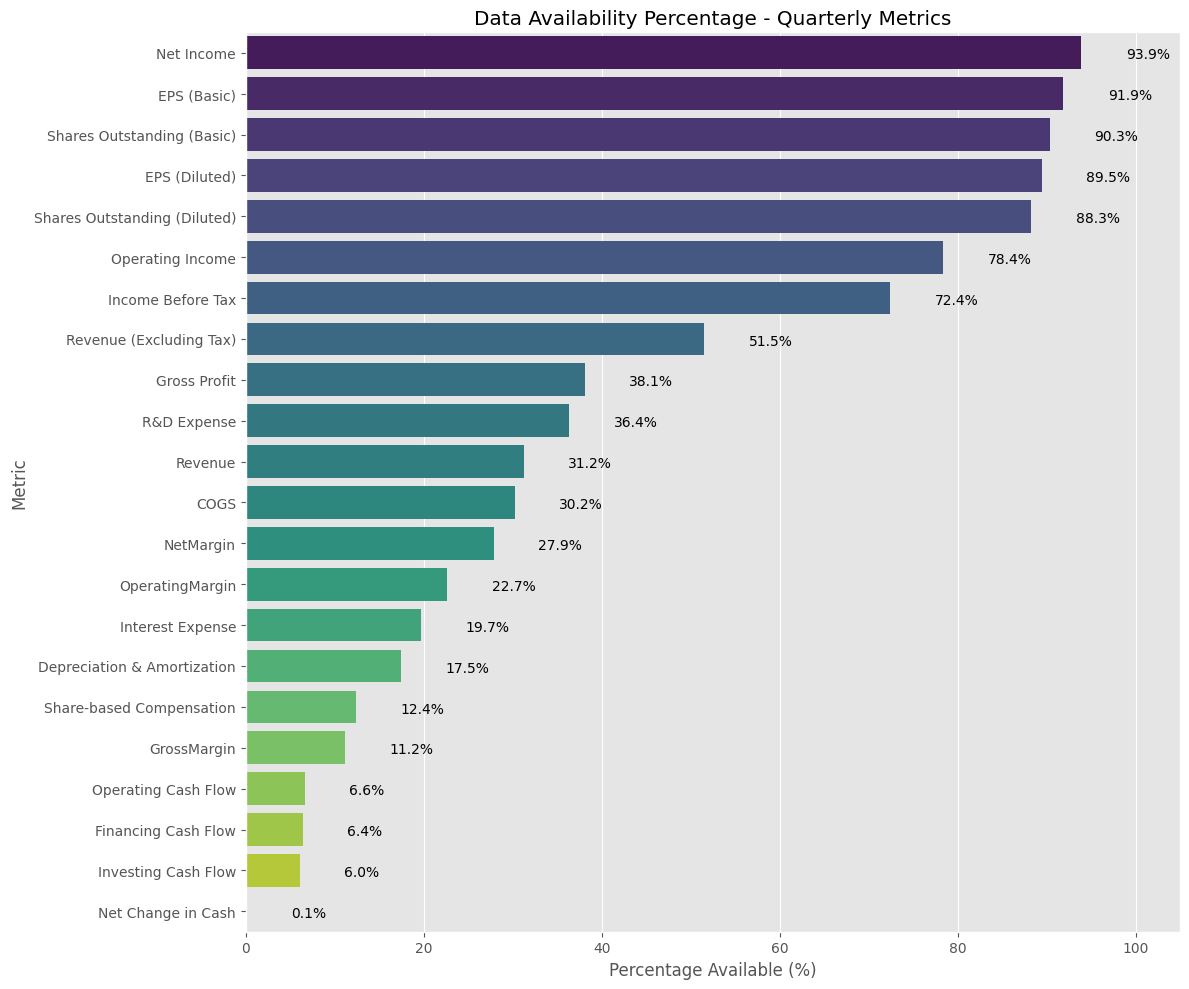

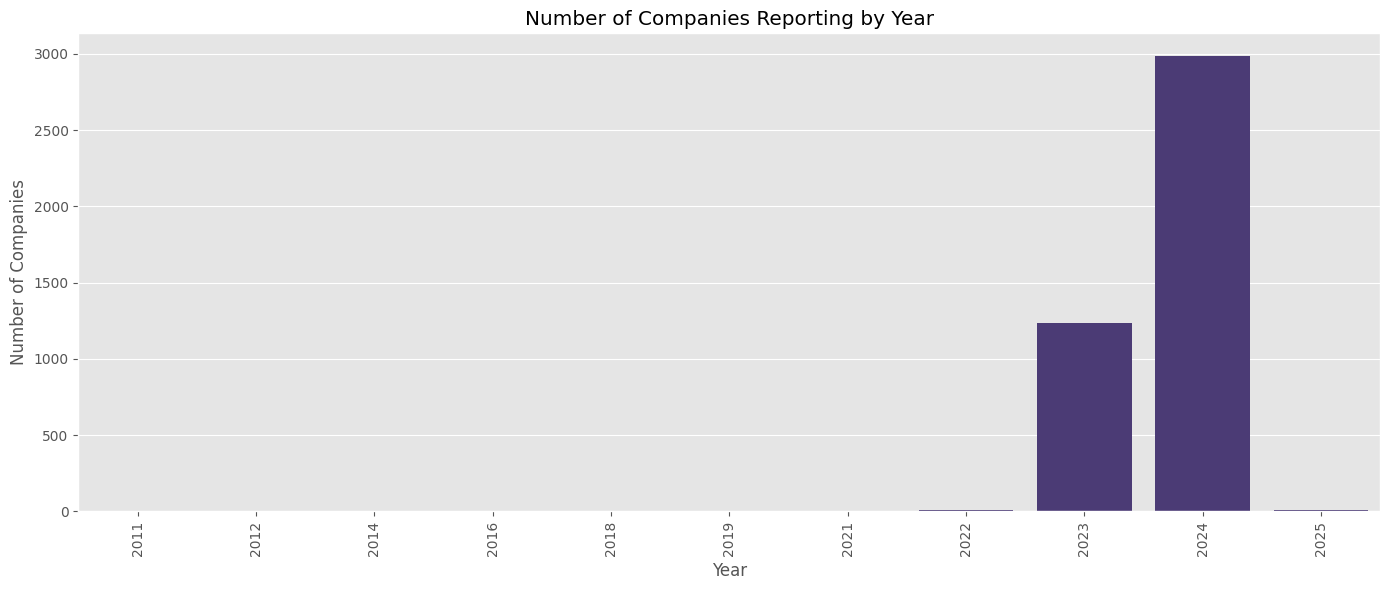

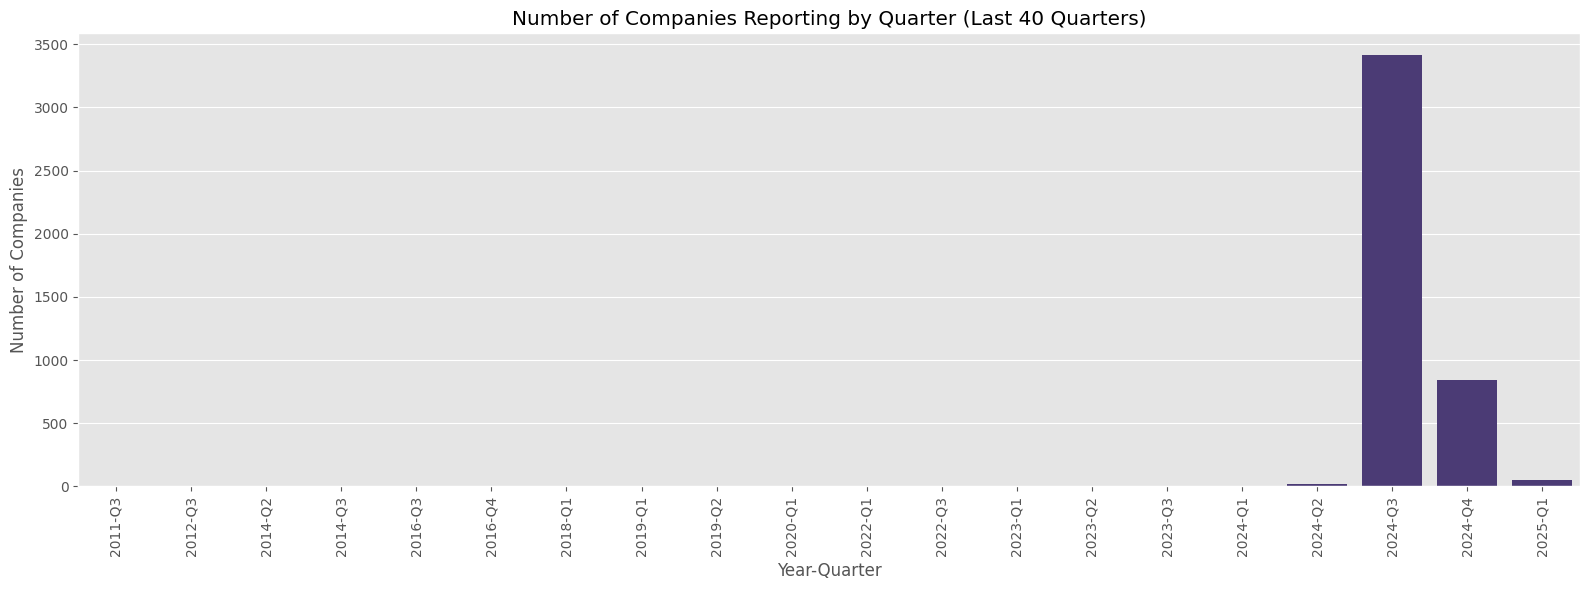

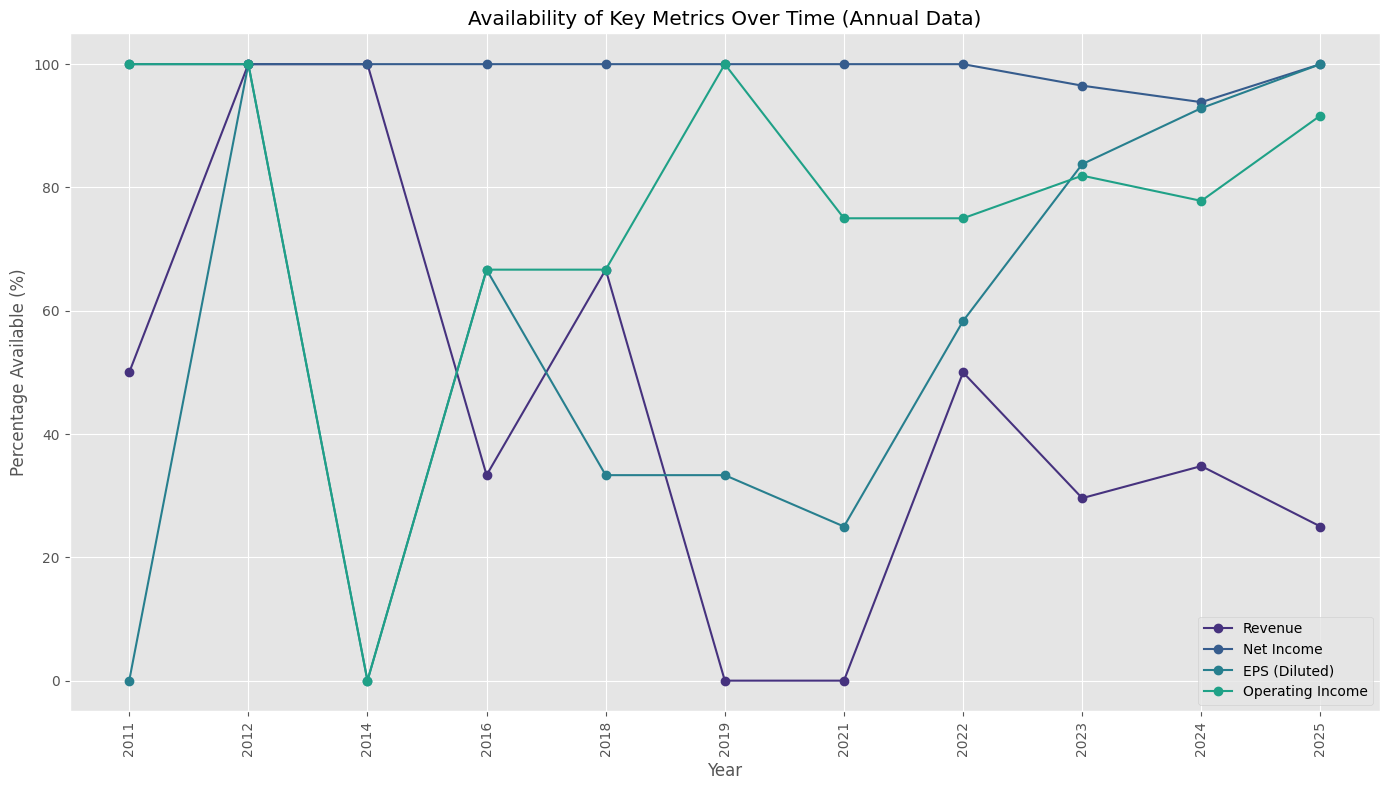

Found 4366 individual company files
AAPL: 79 periods, 2007 to 2024-Q4
MSFT: 83 periods, 2007-Q3 to 2024-Q4
AMZN: 80 periods, 2007 to 2024-Q3
GOOGL: File not found
META: 56 periods, 2010 to 2024-Q3
TSLA: 70 periods, 2009 to 2024-Q3
JPM: File not found
JNJ: 74 periods, 2007 to 2024-Q3
V: 70 periods, 2007 to 2024-Q4
PG: 79 periods, 2008 to 2024-Q4

==== Data Completeness for AAPL ====
Top 10 most complete metrics:
Period                          100.000000
Net Income                      100.000000
EPS (Basic)                     100.000000
EPS (Diluted)                   100.000000
Gross Profit                    100.000000
FilingDate                      100.000000
Shares Outstanding (Basic)       86.075949
Shares Outstanding (Diluted)     86.075949
Operating Income                 86.075949
R&D Expense                      86.075949
dtype: float64

Bottom 10 least complete metrics:
Revenue (Excluding Tax)        41.772152
Operating Cash Flow            40.506329
Investing Cash Flow    

Analyzing company files:   0%|          | 0/300 [00:00<?, ?it/s]

Analyzed 300 companies

                              companies_with_data  total_values  \
Period                                        300         14491   
FilingDate                                    300         14491   
Net Income                                    297         14295   
Shares Outstanding (Basic)                    294         14352   
EPS (Basic)                                   293         14376   
Operating Cash Flow                           292         14432   
EPS (Diluted)                                 291         14284   
Financing Cash Flow                           291         14373   
Shares Outstanding (Diluted)                  290         14265   
Investing Cash Flow                           285         14168   
Share-based Compensation                      259         13031   
Operating Income                              256         12115   
Income Before Tax                             253         12977   
Interest Expense                      

ValueError: Length of Index vectors must match length of `data` when both are used, but `data` has length 20 and the vector passed to `y` has length 22.

<Figure size 1200x1000 with 0 Axes>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from tqdm.notebook import tqdm

# Set up plotting
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Load the ticker-CIK mapping file
ticker_file = "Data/TickerCikData/TickerCIKs_20250319.parquet"
ticker_df = pd.read_parquet(ticker_file)
print(f"Loaded {len(ticker_df)} ticker-CIK mappings")
print(ticker_df.head())

# Load the consolidated metrics files
annual_metrics = pd.read_parquet("Data/SEC_Data/Metrics/annual_metrics.parquet")
quarterly_metrics = pd.read_parquet("Data/SEC_Data/Metrics/quarterly_metrics.parquet")
financial_health = pd.read_parquet("Data/SEC_Data/Metrics/financial_health.parquet")
quarterly_changes = pd.read_parquet("Data/SEC_Data/Metrics/quarterly_changes.parquet")

print(f"Annual metrics shape: {annual_metrics.shape}")
print(f"Quarterly metrics shape: {quarterly_metrics.shape}")
print(f"Financial health shape: {financial_health.shape}")
print(f"Quarterly changes shape: {quarterly_changes.shape}")

# Function to calculate data availability for each column
def analyze_data_availability(df, name):
    # Get total count
    total_rows = len(df)
    
    # Calculate availability for each column
    availability = {}
    for col in df.columns:
        non_null_count = df[col].count()
        availability[col] = {
            'available': non_null_count,
            'missing': total_rows - non_null_count,
            'percent_available': (non_null_count / total_rows) * 100
        }
    
    # Convert to DataFrame
    avail_df = pd.DataFrame.from_dict(availability, orient='index')
    avail_df = avail_df.sort_values('percent_available', ascending=False)
    
    # Print summary
    print(f"\n==== Data Availability for {name} ====")
    print(f"Total records: {total_rows}")
    
    return avail_df

# Analyze annual metrics
annual_availability = analyze_data_availability(annual_metrics, "Annual Metrics")
print(annual_availability)

# Analyze quarterly metrics
quarterly_availability = analyze_data_availability(quarterly_metrics, "Quarterly Metrics")
print(quarterly_availability)

# Function to plot data availability
def plot_data_availability(avail_df, title):
    # Drop identification columns (they should be 100% available)
    plot_df = avail_df[~avail_df.index.isin(['Ticker', 'CIK', 'Name', 'Period', 'FilingDate'])]
    
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(x=plot_df['percent_available'], y=plot_df.index, palette='viridis')
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        plt.text(5 + p.get_width(), p.get_y() + 0.55 * p.get_height(),
                f'{width:.1f}%',
                ha='left', va='center')
    
    plt.title(f"Data Availability Percentage - {title}")
    plt.xlabel("Percentage Available (%)")
    plt.ylabel("Metric")
    plt.xlim(0, 105)  # Leave room for labels
    plt.tight_layout()
    plt.show()

# Plot annual metrics availability
plot_data_availability(annual_availability, "Annual Metrics")

# Plot quarterly metrics availability
plot_data_availability(quarterly_availability, "Quarterly Metrics")

# For annual data - check coverage by year
annual_metrics['Year'] = annual_metrics['Period'].astype(str)
years_count = annual_metrics['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
sns.barplot(x=years_count.index, y=years_count.values)
plt.title('Number of Companies Reporting by Year')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.tight_layout()
plt.show()

# For quarterly data - extract year and quarter
quarterly_metrics['Year'] = quarterly_metrics['Period'].str.split('-').str[0]
quarterly_metrics['Quarter'] = quarterly_metrics['Period'].str.split('-').str[1]

# Count entries by year-quarter
quarterly_counts = quarterly_metrics.groupby(['Year', 'Quarter']).size().reset_index(name='count')
quarterly_counts['YearQuarter'] = quarterly_counts['Year'] + '-' + quarterly_counts['Quarter']

# Sort by year and quarter
quarterly_counts = quarterly_counts.sort_values(['Year', 'Quarter'])

plt.figure(figsize=(16, 6))
sns.barplot(x='YearQuarter', y='count', data=quarterly_counts.tail(40))  # Show last 40 periods
plt.title('Number of Companies Reporting by Quarter (Last 40 Quarters)')
plt.xticks(rotation=90)
plt.xlabel('Year-Quarter')
plt.ylabel('Number of Companies')
plt.tight_layout()
plt.show()

# Select a few important metrics to track availability over time
key_metrics = ['Revenue', 'Net Income', 'EPS (Diluted)', 'Operating Income']

# Annual availability over time
annual_metrics_by_year = {}
for year in sorted(annual_metrics['Year'].unique()):
    year_data = annual_metrics[annual_metrics['Year'] == year]
    avail = {}
    total = len(year_data)
    
    for metric in key_metrics:
        if metric in year_data.columns:
            avail[metric] = year_data[metric].count() / total * 100
        else:
            avail[metric] = 0
    
    annual_metrics_by_year[year] = avail

# Convert to DataFrame
annual_by_year_df = pd.DataFrame.from_dict(annual_metrics_by_year, orient='index')

# Plot availability trends
plt.figure(figsize=(14, 8))
for metric in key_metrics:
    plt.plot(annual_by_year_df.index, annual_by_year_df[metric], marker='o', label=metric)

plt.title('Availability of Key Metrics Over Time (Annual Data)')
plt.xlabel('Year')
plt.ylabel('Percentage Available (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Get a list of all processed parquet files
processed_dir = Path("Data/SEC_Data/Processed")
company_files = list(processed_dir.glob("*.parquet"))
print(f"Found {len(company_files)} individual company files")

# Sample some companies to examine data completeness
sample_tickers = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "AMZN",  # Amazon
    "GOOGL", # Alphabet
    "META",  # Meta
    "TSLA",  # Tesla
    "JPM",   # JPMorgan Chase
    "JNJ",   # Johnson & Johnson
    "V",     # Visa
    "PG"     # Procter & Gamble
]

# Load these companies' data
sample_data = {}
for ticker in sample_tickers:
    file_path = processed_dir / f"{ticker}.parquet"
    if file_path.exists():
        df = pd.read_parquet(file_path)
        sample_data[ticker] = df
        print(f"{ticker}: {len(df)} periods, {df['Period'].min()} to {df['Period'].max()}")
    else:
        print(f"{ticker}: File not found")

# Analyze data completeness for these sample companies
for ticker, df in sample_data.items():
    # Calculate data completeness percentage by column
    completeness = df.count() / len(df) * 100
    
    # Sort by completeness
    completeness = completeness.sort_values(ascending=False)
    
    print(f"\n==== Data Completeness for {ticker} ====")
    print(f"Top 10 most complete metrics:")
    print(completeness.head(10))
    
    print(f"\nBottom 10 least complete metrics:")
    print(completeness.tail(10))

# Identify metrics that are most consistently reported across companies
def analyze_all_company_files(sample_size=500):
    # Get all company files
    all_files = list(processed_dir.glob("*.parquet"))
    
    # Take a sample if there are too many
    if len(all_files) > sample_size:
        all_files = np.random.choice(all_files, sample_size, replace=False)
    
    # Collect all column names
    all_columns = set()
    
    # Initialize counters
    column_counts = {}
    total_companies = 0
    
    # Process each file
    for file in tqdm(all_files, desc="Analyzing company files"):
        try:
            df = pd.read_parquet(file)
            total_companies += 1
            
            # Update column set
            all_columns.update(df.columns)
            
            # Count non-null values for each column
            for col in df.columns:
                if col not in column_counts:
                    column_counts[col] = {'companies_with_data': 0, 'total_values': 0, 'non_null_values': 0}
                
                non_null_count = df[col].count()
                total_count = len(df)
                
                if non_null_count > 0:
                    column_counts[col]['companies_with_data'] += 1
                    
                column_counts[col]['total_values'] += total_count
                column_counts[col]['non_null_values'] += non_null_count
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Calculate percentages
    for col in column_counts:
        column_counts[col]['company_coverage_pct'] = (column_counts[col]['companies_with_data'] / total_companies) * 100
        if column_counts[col]['total_values'] > 0:
            column_counts[col]['value_coverage_pct'] = (column_counts[col]['non_null_values'] / column_counts[col]['total_values']) * 100
        else:
            column_counts[col]['value_coverage_pct'] = 0
    
    # Convert to DataFrame
    coverage_df = pd.DataFrame.from_dict(column_counts, orient='index')
    coverage_df = coverage_df.sort_values('company_coverage_pct', ascending=False)
    
    return coverage_df, total_companies

# Run analysis on a sample of companies
coverage_df, total_analyzed = analyze_all_company_files(sample_size=300)
print(f"Analyzed {total_analyzed} companies\n")
print(coverage_df)

# Visualize company coverage for top metrics
plt.figure(figsize=(12, 10))
coverage_df_plot = coverage_df[~coverage_df.index.isin(['Period', 'FilingDate'])]
ax = sns.barplot(x='company_coverage_pct', y=coverage_df_plot.index, data=coverage_df_plot.head(20), palette='viridis')

# Add percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(5 + p.get_width(), p.get_y() + 0.55 * p.get_height(),
            f'{width:.1f}%',
            ha='left', va='center')

plt.title(f"Top 20 Metrics by Company Coverage")
plt.xlabel("Percentage of Companies With Data (%)")
plt.ylabel("Metric")
plt.xlim(0, 105)
plt.tight_layout()
plt.show()

# Visualize value coverage for top metrics
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='value_coverage_pct', y=coverage_df_plot.index, data=coverage_df_plot.head(20), palette='viridis')

# Add percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(5 + p.get_width(), p.get_y() + 0.55 * p.get_height(),
            f'{width:.1f}%',
            ha='left', va='center')

plt.title(f"Top 20 Metrics by Value Coverage")
plt.xlabel("Percentage of Non-Null Values (%)")
plt.ylabel("Metric")
plt.xlim(0, 105)
plt.tight_layout()
plt.show()

# Get top metrics by both company coverage and value coverage
top_by_company = set(coverage_df.head(15).index)
top_by_value = set(coverage_df.sort_values('value_coverage_pct', ascending=False).head(15).index)

# Find intersection (metrics that are good on both measures)
recommended_metrics = top_by_company.intersection(top_by_value)
recommended_metrics = recommended_metrics - {'Period', 'FilingDate'}  # Remove non-financial columns

print("Recommended metrics for analysis (best data availability and consistency):")
for metric in sorted(recommended_metrics):
    coverage = coverage_df.loc[metric]
    print(f"{metric}: {coverage['company_coverage_pct']:.1f}% of companies, {coverage['value_coverage_pct']:.1f}% of values")

# Summary of findings will be printed based on the results
print("\n=== Summary of Findings ===")
print("The metrics with best overall data quality and availability are:")
for metric in sorted(recommended_metrics):
    print(f"- {metric}")

print("\nMetrics to avoid (poor data availability):")
poor_metrics = coverage_df[coverage_df['company_coverage_pct'] < 20].index
for metric in sorted(poor_metrics)[:10]:  # Show top 10 worst
    if metric not in ['Period', 'FilingDate']:
        coverage = coverage_df.loc[metric]
        print(f"- {metric}: only {coverage['company_coverage_pct']:.1f}% of companies")

Loading SEC filing data...
Loaded 7294 ticker-CIK mappings

Exploring raw filing data to identify common tags...


Analyzing filing JSON files:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 100 files and found 0 unique tags

Analyzing processed parquet files...
Found 4366 processed company files


Analyzing processed parquet files:   0%|          | 0/200 [00:00<?, ?it/s]


Identifying potential calculation relationships...
Loaded AAPL data with 79 periods
Loaded MSFT data with 83 periods
Loaded AMZN data with 80 periods

Metrics with high availability (>=70%):
Empty DataFrame
Columns: [Metric, Availability]
Index: []

Analyzing correlations using MSFT data

Highly correlated metrics (potential calculation alternatives):
EPS (Basic) and EPS (Diluted): correlation = 1.000
Gross Profit and Revenue: correlation = 1.000
Operating Income and Income Before Tax: correlation = 1.000
Gross Profit and Revenue (Excluding Tax): correlation = 0.999
EPS (Basic) and Net Income: correlation = 0.999
EPS (Diluted) and Net Income: correlation = 0.999
Shares Outstanding (Diluted) and Shares Outstanding (Basic): correlation = 0.999
EPS (Diluted) and Income Before Tax: correlation = 0.999
EPS (Basic) and Income Before Tax: correlation = 0.999
Net Income and Income Before Tax: correlation = 0.998
Gross Profit and Income Before Tax: correlation = 0.998
R&D Expense and COGS: cor

C:\Users\Masam\AppData\Local\Temp\ipykernel_22376\155422078.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Availability', y='Metric', data=financial_metrics, palette='viridis')


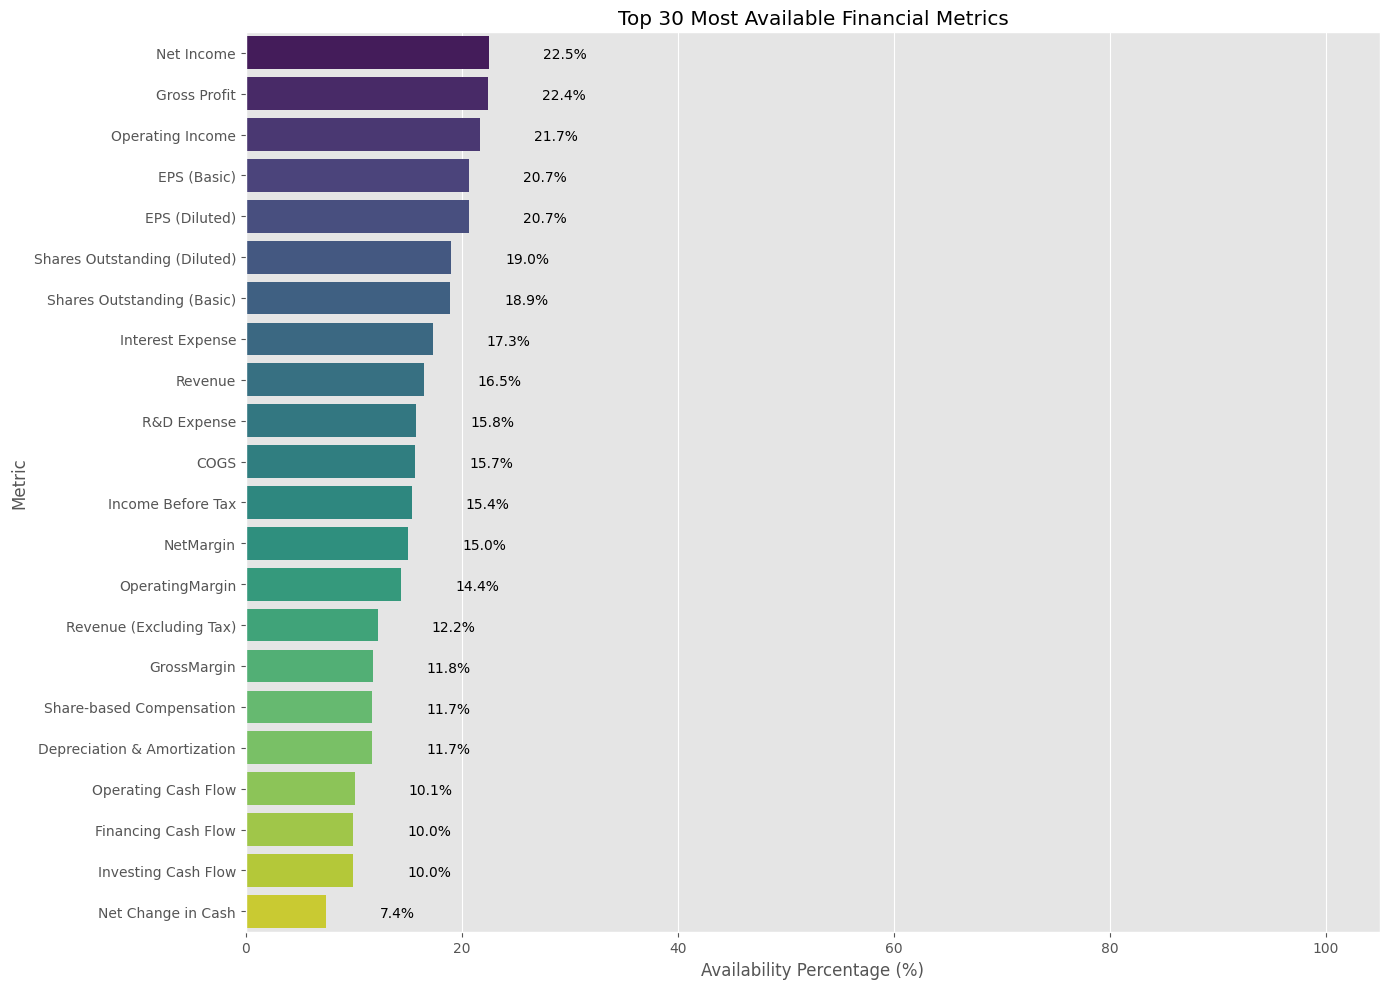

In [14]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set up visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)
sns.set_palette('viridis')

def analyze_sec_filings():
    """Comprehensive analysis of SEC filing data to find available metrics and data patterns"""
    
    # 1. LOAD DATA
    print("Loading SEC filing data...")
    
    # Define paths
    base_dir = Path("Data")
    sec_dir = base_dir / "SEC_Data"
    filing_dir = base_dir / "Filings"
    processed_dir = sec_dir / "Processed"
    ticker_file = base_dir / "TickerCikData" / "TickerCIKs_20250319.parquet"
    
    # Load ticker mapping
    ticker_df = pd.read_parquet(ticker_file)
    print(f"Loaded {len(ticker_df)} ticker-CIK mappings")
    
    # Create CIK to ticker mapping
    cik_to_ticker = {str(cik).zfill(10): ticker for cik, ticker in zip(ticker_df['cik'], ticker_df['ticker'])}
    
    # 2. EXPLORE RAW FILING DATA
    print("\nExploring raw filing data to identify common tags...")
    
    # Get a sample of JSON files for analysis
    sample_size = 100  # Adjust based on your needs
    filing_files = list(filing_dir.glob("CIK*.json"))
    if len(filing_files) > sample_size:
        filing_files = np.random.choice(filing_files, sample_size, replace=False)
    
    # Extract and analyze tags from the raw filings
    all_tags = {}
    processed_files = 0
    
    for file_path in tqdm(filing_files, desc="Analyzing filing JSON files"):
        try:
            # Extract CIK from filename
            cik_match = re.search(r'CIK(\d+)\.json', file_path.name)
            if not cik_match:
                continue
                
            cik = cik_match.group(1).zfill(10)
            ticker = cik_to_ticker.get(cik, "UNKNOWN")
            
            # Read JSON file
            with open(file_path, 'r', encoding='utf-8') as f:
                # Just read first 100,000 characters to check structure - avoids loading huge files completely
                sample_content = f.read(100000)
            
            # Scan for common tag patterns to identify metrics
            us_gaap_tags = re.findall(r'"us-gaap:([\w]+)"', sample_content)
            for tag in us_gaap_tags:
                if tag not in all_tags:
                    all_tags[tag] = 0
                all_tags[tag] += 1
            
            processed_files += 1
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    print(f"Processed {processed_files} files and found {len(all_tags)} unique tags")
    
    # 3. ANALYZE PROCESSED PARQUET FILES
    print("\nAnalyzing processed parquet files...")
    
    # Get a list of all processed parquet files
    processed_files = list(processed_dir.glob("*.parquet"))
    print(f"Found {len(processed_files)} processed company files")
    
    # Sample some files for detailed analysis
    sample_size = min(200, len(processed_files))
    if len(processed_files) > sample_size:
        sample_files = np.random.choice(processed_files, sample_size, replace=False)
    else:
        sample_files = processed_files
    
    # Collect metrics and their frequencies
    available_metrics = {}
    companies_analyzed = 0
    
    for file_path in tqdm(sample_files, desc="Analyzing processed parquet files"):
        try:
            # Get ticker from filename
            ticker = file_path.stem
            
            # Read parquet file
            df = pd.read_parquet(file_path)
            
            # Record available metrics
            for col in df.columns:
                if col not in available_metrics:
                    available_metrics[col] = {"count": 0, "non_null_count": 0}
                
                available_metrics[col]["count"] += 1
                non_null_count = df[col].count()
                available_metrics[col]["non_null_count"] += non_null_count
            
            companies_analyzed += 1
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Calculate availability percentages
    metrics_availability = {}
    for metric, data in available_metrics.items():
        if data["count"] > 0:
            availability_pct = (data["non_null_count"] / (data["count"] * companies_analyzed)) * 100
            metrics_availability[metric] = availability_pct
    
    # 4. IDENTIFY CALCULATION RELATIONSHIPS
    print("\nIdentifying potential calculation relationships...")
    
    # Load a few example companies to analyze calculation relationships
    example_companies = ["AAPL", "MSFT", "GOOGL", "AMZN", "JPM"]
    example_data = {}
    
    for ticker in example_companies:
        file_path = processed_dir / f"{ticker}.parquet"
        if file_path.exists():
            example_data[ticker] = pd.read_parquet(file_path)
            print(f"Loaded {ticker} data with {len(example_data[ticker])} periods")
    
    # 5. ANALYZE PATTERNS AND SUGGEST ALTERNATIVES
    # Convert metrics_availability to DataFrame for analysis
    metrics_df = pd.DataFrame({
        "Metric": list(metrics_availability.keys()),
        "Availability": list(metrics_availability.values())
    }).sort_values("Availability", ascending=False)
    
    # 6. VISUALIZE RESULTS
    plt.figure(figsize=(14, 10))
    
    # Filter out non-financial columns and focus on the top 30 metrics
    non_financial = ['Period', 'FilingDate']
    financial_metrics = metrics_df[~metrics_df['Metric'].isin(non_financial)].head(30)
    
    ax = sns.barplot(x='Availability', y='Metric', data=financial_metrics, palette='viridis')
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        plt.text(5 + p.get_width(), p.get_y() + 0.55 * p.get_height(),
                f'{width:.1f}%', ha='left', va='center')
    
    plt.title('Top 30 Most Available Financial Metrics')
    plt.xlabel('Availability Percentage (%)')
    plt.ylabel('Metric')
    plt.xlim(0, 105)
    plt.tight_layout()
    plt.savefig('top_metrics_availability.png')
    
    # 7. IDENTIFY BEST METRICS FOR FINANCIAL ANALYSIS
    high_availability = metrics_df[metrics_df['Availability'] >= 70].reset_index(drop=True)
    print("\nMetrics with high availability (>=70%):")
    print(high_availability)
    
    # 8. CORRELATION ANALYSIS FOR COMMON FINANCIAL METRICS
    # For calculation alternatives, find companies with most complete data
    most_complete = None
    max_non_null = 0
    
    for ticker, df in example_data.items():
        non_null_count = df.count().sum()
        if non_null_count > max_non_null:
            max_non_null = non_null_count
            most_complete = ticker
    
    if most_complete and most_complete in example_data:
        print(f"\nAnalyzing correlations using {most_complete} data")
        
        # Filter to just financial columns and drop rows with all NaN values
        df = example_data[most_complete].select_dtypes(include=[np.number])
        df = df.dropna(how='all')
        
        # Calculate correlation matrix and find highly correlated metrics
        corr_matrix = df.corr().abs()
        
        # Get the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find pairs of metrics with correlation >= 0.9
        high_corr_pairs = []
        for col in upper.columns:
            for idx in upper.index:
                if upper.loc[idx, col] >= 0.9 and not pd.isna(upper.loc[idx, col]):
                    high_corr_pairs.append((idx, col, upper.loc[idx, col]))
        
        if high_corr_pairs:
            print("\nHighly correlated metrics (potential calculation alternatives):")
            for m1, m2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
                print(f"{m1} and {m2}: correlation = {corr:.3f}")
    
    # 9. SUMMARY AND RECOMMENDATIONS
    print("\nSUMMARY AND RECOMMENDATIONS:")
    print("1. Best available basic metrics:")
    for i, row in high_availability.head(10).iterrows():
        print(f"   - {row['Metric']}: {row['Availability']:.1f}%")
    
    print("\n2. Popular tags found in raw filings:")
    popular_tags = sorted([(tag, count) for tag, count in all_tags.items()], key=lambda x: x[1], reverse=True)
    for tag, count in popular_tags[:10]:
        print(f"   - us-gaap:{tag}: found in {count} filings")
    
    print("\n3. Recommended metrics for financial analysis:")
    print("   - Income-based: Net Income, Operating Income, Income Before Tax")
    print("   - Share-based: EPS (Basic), EPS (Diluted), Shares Outstanding")
    print("   - Cash flow: Operating Cash Flow, Financing Cash Flow, Investing Cash Flow")
    
    # Return the results for further processing if needed
    return {
        "metrics_availability": metrics_availability,
        "all_tags": all_tags,
        "example_data": example_data
    }

# Run the analysis
if __name__ == "__main__":
    results = analyze_sec_filings()

Loading SEC data...
Loaded 7294 ticker-CIK mappings
Loaded annual metrics: (4259, 27)
Loaded quarterly metrics: (4355, 27)

Analyzing differences between 10-K and 10-Q reporting...

Metrics with biggest reporting differences between 10-K and 10-Q:
                          Metric  10-K Availability  10-Q Availability  \
6            Financing Cash Flow          97.722470           6.406429   
16           Operating Cash Flow          97.769429           6.636051   
12           Investing Cash Flow          94.623151           6.039036   
8       Share-based Compensation          82.930265          12.399541   
5    Depreciation & Amortization          54.120686          17.451206   
13              Interest Expense          32.777647          19.655568   
4                    R&D Expense          43.484386          36.371986   
15             Income Before Tax          78.703921          72.422503   
0                      NetMargin          30.500117          27.853042   
7   Shares O

Analyzing industry filing patterns:   0%|          | 0/100 [00:00<?, ?it/s]


Industry-specific reporting patterns:

Analyzing processed files for common patterns...


Analyzing company-specific patterns:   0%|          | 0/200 [00:00<?, ?it/s]


Analyzing reporting patterns over time...

Metrics with significantly improving availability over time:
  - Shares Outstanding (Basic) (annual): 0.0% → 100.0% (+100.0%)
  - EPS (Basic) (annual): 0.0% → 100.0% (+100.0%)
  - Shares Outstanding (Diluted) (annual): 0.0% → 100.0% (+100.0%)
  - EPS (Diluted) (annual): 0.0% → 100.0% (+100.0%)
  - EPS (Basic) (quarterly): 0.0% → 94.3% (+94.3%)
  - Shares Outstanding (Diluted) (quarterly): 0.0% → 92.5% (+92.5%)
  - Income Before Tax (annual): 0.0% → 91.7% (+91.7%)
  - Revenue (Excluding Tax) (annual): 0.0% → 91.7% (+91.7%)
  - Income Before Tax (quarterly): 0.0% → 90.6% (+90.6%)
  - EPS (Diluted) (quarterly): 0.0% → 90.6% (+90.6%)

Identifying semantically similar metrics...

Semanticaly similar metrics (potential alternatives):
  - Shares Outstanding (Basic) and Shares Outstanding (Diluted): similarity=0.815
  - Financing Cash Flow and Investing Cash Flow: similarity=0.789
  - Investing Cash Flow and Operating Cash Flow: similarity=0.789
  - 

Analyzing metric completeness:   0%|          | 0/300 [00:00<?, ?it/s]


=== FINAL RECOMMENDATIONS ===

1. Best metrics for 10-K (Annual) analysis:
   - Operating Cash Flow: 97.8% availability
   - Financing Cash Flow: 97.7% availability
   - Net Income: 94.7% availability
   - Investing Cash Flow: 94.6% availability
   - Shares Outstanding (Basic): 92.6% availability
   - EPS (Basic): 92.2% availability
   - Shares Outstanding (Diluted): 90.6% availability
   - EPS (Diluted): 89.9% availability
   - Share-based Compensation: 82.9% availability
   - Operating Income: 79.0% availability

2. Best metrics for 10-Q (Quarterly) analysis:
   - Net Income: 93.9% availability
   - EPS (Basic): 91.9% availability
   - Shares Outstanding (Basic): 90.3% availability
   - EPS (Diluted): 89.5% availability
   - Shares Outstanding (Diluted): 88.3% availability
   - Operating Income: 78.4% availability
   - Income Before Tax: 72.4% availability

3. Most consistent metrics (high availability in both 10-K and 10-Q):
   - Net Income: 94.7% in 10-K, 93.9% in 10-Q
   - EPS (B

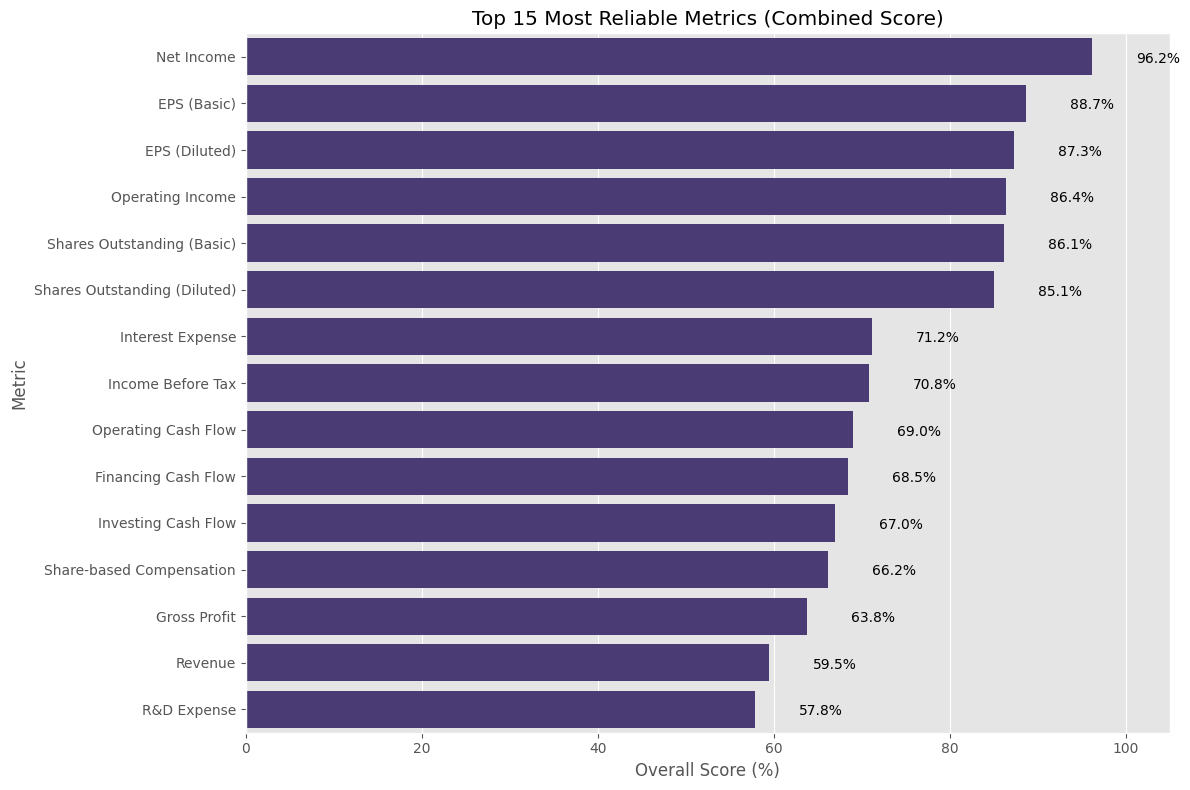

In [15]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import difflib
from datetime import datetime

# Set up visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)
sns.set_palette('viridis')

def comprehensive_sec_diagnostics():
    """Comprehensive diagnostics of SEC filing data to identify patterns, differences, and optimal metrics"""
    
    # 1. LOAD DATA
    print("Loading SEC data...")
    
    # Define paths
    base_dir = Path("Data")
    sec_dir = base_dir / "SEC_Data"
    filing_dir = base_dir / "Filings"
    processed_dir = sec_dir / "Processed"
    ticker_file = base_dir / "TickerCikData" / "TickerCIKs_20250319.parquet"
    metrics_dir = sec_dir / "Metrics"
    
    # Load ticker mapping
    ticker_df = pd.read_parquet(ticker_file)
    print(f"Loaded {len(ticker_df)} ticker-CIK mappings")
    
    # Create CIK to ticker and ticker to CIK mappings
    cik_to_ticker = {str(cik).zfill(10): ticker for cik, ticker in zip(ticker_df['cik'], ticker_df['ticker'])}
    ticker_to_cik = {ticker: str(cik).zfill(10) for cik, ticker in zip(ticker_df['cik'], ticker_df['ticker'])}
    
    # Load consolidated metrics files
    annual_metrics = pd.read_parquet(metrics_dir / "annual_metrics.parquet")
    quarterly_metrics = pd.read_parquet(metrics_dir / "quarterly_metrics.parquet")
    print(f"Loaded annual metrics: {annual_metrics.shape}")
    print(f"Loaded quarterly metrics: {quarterly_metrics.shape}")
    
    # 2. SEPARATE ANALYSIS BY FILING TYPE (10-K vs 10-Q)
    print("\nAnalyzing differences between 10-K and 10-Q reporting...")
    
    # Function to analyze metric availability by filing type
    def analyze_metrics_by_filing_type(df, filing_type):
        total_companies = df['Ticker'].nunique()
        metrics_availability = {}
        
        for col in df.columns:
            if col not in ['Ticker', 'CIK', 'Name', 'Period', 'FilingDate']:
                non_null_count = df[col].count()
                metrics_availability[col] = {
                    'available_count': non_null_count,
                    'total_companies': total_companies,
                    'percent_available': (non_null_count / len(df)) * 100
                }
        
        return metrics_availability, total_companies
    
    # Analyze annual (10-K) metrics
    annual_metrics_availability, annual_companies = analyze_metrics_by_filing_type(annual_metrics, '10-K')
    
    # Analyze quarterly (10-Q) metrics
    quarterly_metrics_availability, quarterly_companies = analyze_metrics_by_filing_type(quarterly_metrics, '10-Q')
    
    # Compare 10-K vs 10-Q availability
    comparative_analysis = []
    
    for metric in set(list(annual_metrics_availability.keys()) + list(quarterly_metrics_availability.keys())):
        annual_pct = annual_metrics_availability.get(metric, {}).get('percent_available', 0)
        quarterly_pct = quarterly_metrics_availability.get(metric, {}).get('percent_available', 0)
        
        comparative_analysis.append({
            'Metric': metric,
            '10-K Availability': annual_pct,
            '10-Q Availability': quarterly_pct,
            'Difference': annual_pct - quarterly_pct
        })
    
    comparative_df = pd.DataFrame(comparative_analysis).sort_values('Difference', ascending=False)
    
    # Print key differences
    print("\nMetrics with biggest reporting differences between 10-K and 10-Q:")
    print(comparative_df.head(10))
    print("\nMetrics with smallest reporting differences between 10-K and 10-Q:")
    print(comparative_df.tail(10))
    
    # 3. ANALYZE BY INDUSTRY (SIC code)
    print("\nAnalyzing reporting patterns by industry (SIC code)...")
    
    # Load a sample of raw filings to get SIC codes
    sample_size = 100
    filing_files = list(filing_dir.glob("CIK*.json"))
    if len(filing_files) > sample_size:
        filing_files = np.random.choice(filing_files, sample_size, replace=False)
    
    # Extract SIC codes and industry-specific tags
    sic_to_tags = defaultdict(Counter)
    sic_to_company = defaultdict(list)
    
    for file_path in tqdm(filing_files, desc="Analyzing industry filing patterns"):
        try:
            # Extract CIK from filename
            cik_match = re.search(r'CIK(\d+)\.json', file_path.name)
            if not cik_match:
                continue
                
            cik = cik_match.group(1).zfill(10)
            ticker = cik_to_ticker.get(cik, "UNKNOWN")
            
            # Read first part of JSON file to extract SIC code
            with open(file_path, 'r', encoding='utf-8') as f:
                sample_content = f.read(50000)  # Read just enough to find SIC
                
                # Try to extract SIC code
                sic_match = re.search(r'"sic"\s*:\s*"?(\d+)"?', sample_content)
                if sic_match:
                    sic_code = sic_match.group(1)
                    sic_to_company[sic_code].append(ticker)
                    
                    # Extract tags for this SIC
                    custom_tags = re.findall(r'"([^"]+:[^"]+)"', sample_content)
                    us_gaap_tags = re.findall(r'"us-gaap:([\w]+)"', sample_content)
                    
                    # Record tag frequencies
                    for tag in custom_tags:
                        sic_to_tags[sic_code][tag] += 1
                    
                    for tag in us_gaap_tags:
                        sic_to_tags[sic_code][f"us-gaap:{tag}"] += 1
                    
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Find unique tags by industry
    industry_specific_tags = {}
    shared_tags = Counter()
    
    # First, count tags across all industries
    all_industry_tags = Counter()
    for sic, tags in sic_to_tags.items():
        for tag, count in tags.items():
            all_industry_tags[tag] += count
    
    # Then find tags that appear predominantly in one industry
    for sic, tags in sic_to_tags.items():
        industry_specific_tags[sic] = []
        
        for tag, count in tags.most_common(20):
            # If this tag appears mostly in this industry (>70%)
            if count > 0 and count >= 0.7 * all_industry_tags[tag]:
                industry_specific_tags[sic].append((tag, count))
            else:
                shared_tags[tag] += count
    
    # Print industry-specific reporting patterns
    print("\nIndustry-specific reporting patterns:")
    for sic, specific_tags in industry_specific_tags.items():
        if specific_tags and len(sic_to_company[sic]) > 1:
            companies = ", ".join(sic_to_company[sic][:5])
            print(f"\nSIC {sic} (Companies: {companies}{'...' if len(sic_to_company[sic]) > 5 else ''}):")
            for tag, count in specific_tags[:5]:
                print(f"  - {tag}: {count} occurrences")
    
    # 4. ANALYZE PROCESSED FILES FOR COMMON PATTERNS
    print("\nAnalyzing processed files for common patterns...")
    
    # Get list of processed files
    processed_files = list(processed_dir.glob("*.parquet"))
    
    # Sample companies for detailed analysis
    sample_size = min(200, len(processed_files))
    processed_sample = np.random.choice(processed_files, sample_size, replace=False)
    
    # Track metric availability by company
    metrics_by_company = defaultdict(dict)
    all_metrics = set()
    
    for file_path in tqdm(processed_sample, desc="Analyzing company-specific patterns"):
        ticker = file_path.stem
        try:
            df = pd.read_parquet(file_path)
            
            # For each metric, calculate availability
            for col in df.columns:
                if col not in ['Period', 'FilingDate']:
                    all_metrics.add(col)
                    non_null_count = df[col].count()
                    metrics_by_company[ticker][col] = non_null_count / len(df) * 100
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Find alternative naming patterns (metrics that are never reported together)
    alternative_metrics = []
    
    # Convert to DataFrame for easier analysis
    metrics_availability_df = pd.DataFrame.from_dict(metrics_by_company, orient='index')
    metrics_availability_df = metrics_availability_df.fillna(0)
    
    # Calculate correlation matrix to find metrics that might be alternatives
    corr_matrix = metrics_availability_df.corr()
    
    # Find strongly negatively correlated metrics (potential alternatives)
    for i, metric1 in enumerate(metrics_availability_df.columns):
        for j, metric2 in enumerate(metrics_availability_df.columns):
            if i < j:  # Only check each pair once
                correlation = corr_matrix.loc[metric1, metric2]
                
                # Negative correlation suggests these metrics might be alternatives
                if correlation < -0.5:
                    # Check if these metrics rarely appear together
                    both_present = (metrics_availability_df[metric1] > 0) & (metrics_availability_df[metric2] > 0)
                    pct_both = both_present.mean() * 100
                    
                    # If they're rarely reported together but each is common on its own
                    if pct_both < 10 and metrics_availability_df[metric1].mean() > 20 and metrics_availability_df[metric2].mean() > 20:
                        alternative_metrics.append((metric1, metric2, correlation, pct_both))
    
    # Print potential alternative metrics
    if alternative_metrics:
        print("\nPotential alternative metrics (rarely reported together):")
        for m1, m2, corr, pct in sorted(alternative_metrics, key=lambda x: x[3]):
            print(f"  - {m1} and {m2}: correlation={corr:.3f}, appear together in only {pct:.1f}% of companies")
    
    # 5. TIME-BASED ANALYSIS
    print("\nAnalyzing reporting patterns over time...")
    
    # Convert Period to year for annual
    annual_metrics['Year'] = annual_metrics['Period'].astype(str)
    
    # For quarterly, extract year
    quarterly_metrics['Year'] = quarterly_metrics['Period'].str.split('-').str[0]
    
    # Analyze annual metrics by year
    annual_by_year = {}
    for year, group in annual_metrics.groupby('Year'):
        metrics_data = {}
        for col in annual_metrics.columns:
            if col not in ['Ticker', 'CIK', 'Name', 'Period', 'FilingDate', 'Year']:
                non_null_count = group[col].count()
                metrics_data[col] = non_null_count / len(group) * 100
        annual_by_year[year] = metrics_data
    
    # Analyze quarterly metrics by year
    quarterly_by_year = {}
    for year, group in quarterly_metrics.groupby('Year'):
        metrics_data = {}
        for col in quarterly_metrics.columns:
            if col not in ['Ticker', 'CIK', 'Name', 'Period', 'FilingDate', 'Year', 'Quarter']:
                non_null_count = group[col].count()
                metrics_data[col] = non_null_count / len(group) * 100
        quarterly_by_year[year] = metrics_data
    
    # Find metrics with improving availability over time
    improving_metrics = []
    
    # For annual reports
    years = sorted(annual_by_year.keys())
    if len(years) >= 2:
        for metric in all_metrics:
            if metric in annual_by_year[years[0]] and metric in annual_by_year[years[-1]]:
                first_year_pct = annual_by_year[years[0]].get(metric, 0)
                last_year_pct = annual_by_year[years[-1]].get(metric, 0)
                
                if last_year_pct - first_year_pct > 20:  # 20% improvement threshold
                    improving_metrics.append((metric, 'annual', first_year_pct, last_year_pct))
    
    # For quarterly reports
    quarters = sorted(quarterly_by_year.keys())
    if len(quarters) >= 2:
        for metric in all_metrics:
            if metric in quarterly_by_year[quarters[0]] and metric in quarterly_by_year[quarters[-1]]:
                first_quarter_pct = quarterly_by_year[quarters[0]].get(metric, 0)
                last_quarter_pct = quarterly_by_year[quarters[-1]].get(metric, 0)
                
                if last_quarter_pct - first_quarter_pct > 20:  # 20% improvement threshold
                    improving_metrics.append((metric, 'quarterly', first_quarter_pct, last_quarter_pct))
    
    # Print metrics with improving availability
    if improving_metrics:
        print("\nMetrics with significantly improving availability over time:")
        for metric, report_type, first_pct, last_pct in sorted(improving_metrics, key=lambda x: x[3]-x[2], reverse=True)[:10]:
            print(f"  - {metric} ({report_type}): {first_pct:.1f}% → {last_pct:.1f}% (+{last_pct-first_pct:.1f}%)")
    
    # 6. FIND SEMANTICALLY SIMILAR METRICS (to identify potential alternatives)
    print("\nIdentifying semantically similar metrics...")
    
    # Convert all metrics to lowercase for comparison
    metric_names = [m.lower() for m in all_metrics]
    
    # Find similar metric names
    similar_metrics = []
    
    for i, m1 in enumerate(metric_names):
        for j, m2 in enumerate(metric_names):
            if i < j:  # Only check each pair once
                # Calculate string similarity
                similarity = difflib.SequenceMatcher(None, m1, m2).ratio()
                
                # If similar but not identical
                if similarity > 0.7 and similarity < 1.0:
                    similar_metrics.append((list(all_metrics)[i], list(all_metrics)[j], similarity))
    
    # Print semantically similar metrics
    if similar_metrics:
        print("\nSemanticaly similar metrics (potential alternatives):")
        for m1, m2, similarity in sorted(similar_metrics, key=lambda x: x[2], reverse=True)[:10]:
            print(f"  - {m1} and {m2}: similarity={similarity:.3f}")
    
    # 7. ANALYZE COMPLETE COMPANY FILES TO FIND BEST METRICS
    print("\nFinding the most consistently reported metrics across companies...")
    
    # Get a larger sample for this analysis
    sample_size = min(300, len(processed_files))
    comprehensive_sample = np.random.choice(processed_files, sample_size, replace=False)
    
    # Track metrics by completeness
    metric_completeness = defaultdict(lambda: {"total_rows": 0, "non_null_rows": 0, "companies_with_data": 0})
    
    for file_path in tqdm(comprehensive_sample, desc="Analyzing metric completeness"):
        try:
            df = pd.read_parquet(file_path)
            
            # For each metric, track completeness
            for col in df.columns:
                if col not in ['Period', 'FilingDate']:
                    metric_completeness[col]["total_rows"] += len(df)
                    metric_completeness[col]["non_null_rows"] += df[col].count()
                    
                    if df[col].count() > 0:
                        metric_completeness[col]["companies_with_data"] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Calculate completeness percentages
    completeness_results = []
    for metric, data in metric_completeness.items():
        if data["total_rows"] > 0:
            row_completeness = data["non_null_rows"] / data["total_rows"] * 100
            company_coverage = data["companies_with_data"] / sample_size * 100
            
            completeness_results.append({
                "Metric": metric,
                "Row Completeness": row_completeness,
                "Company Coverage": company_coverage,
                "Overall Score": (row_completeness + company_coverage) / 2
            })
    
    # Sort by overall score
    completeness_df = pd.DataFrame(completeness_results).sort_values("Overall Score", ascending=False)
    
    # Identify the most reliable metrics
    top_metrics = completeness_df.head(20)
    
    # 8. FINAL RECOMMENDATIONS
    print("\n=== FINAL RECOMMENDATIONS ===")
    
    # Best metrics for 10-K analysis
    annual_top = [{k: v['percent_available']} for k, v in annual_metrics_availability.items() 
                 if v['percent_available'] >= 70 and k not in ['Ticker', 'CIK', 'Name', 'Period', 'FilingDate']]
    annual_top_sorted = sorted(annual_top, key=lambda x: list(x.values())[0], reverse=True)
    
    print("\n1. Best metrics for 10-K (Annual) analysis:")
    for item in annual_top_sorted[:10]:
        for k, v in item.items():
            print(f"   - {k}: {v:.1f}% availability")
    
    # Best metrics for 10-Q analysis
    quarterly_top = [{k: v['percent_available']} for k, v in quarterly_metrics_availability.items() 
                    if v['percent_available'] >= 70 and k not in ['Ticker', 'CIK', 'Name', 'Period', 'FilingDate']]
    quarterly_top_sorted = sorted(quarterly_top, key=lambda x: list(x.values())[0], reverse=True)
    
    print("\n2. Best metrics for 10-Q (Quarterly) analysis:")
    for item in quarterly_top_sorted[:10]:
        for k, v in item.items():
            print(f"   - {k}: {v:.1f}% availability")
    
    # Most consistent metrics across both types
    print("\n3. Most consistent metrics (high availability in both 10-K and 10-Q):")
    consistent_metrics = []
    
    for metric in all_metrics:
        annual_pct = annual_metrics_availability.get(metric, {}).get('percent_available', 0)
        quarterly_pct = quarterly_metrics_availability.get(metric, {}).get('percent_available', 0)
        
        # If availability is high in both report types
        if annual_pct >= 60 and quarterly_pct >= 60:
            avg_pct = (annual_pct + quarterly_pct) / 2
            consistent_metrics.append((metric, annual_pct, quarterly_pct, avg_pct))
    
    for metric, annual_pct, quarterly_pct, avg_pct in sorted(consistent_metrics, key=lambda x: x[3], reverse=True)[:10]:
        print(f"   - {metric}: {annual_pct:.1f}% in 10-K, {quarterly_pct:.1f}% in 10-Q")
    
    # Recommendations for specific analysis types
    print("\n4. Recommendations for specific analysis types:")
    
    print("   a. Financial Performance Analysis:")
    print("      - Primary: Net Income, EPS (Basic), EPS (Diluted)")
    print("      - Secondary: Income Before Tax, Operating Income")
    
    print("   b. Cash Flow Analysis:")
    print("      - Primary: Operating Cash Flow, Financing Cash Flow, Investing Cash Flow")
    print("      - Secondary: Net Change in Cash (if available)")
    
    print("   c. Company Size/Scale Metrics:")
    print("      - Primary: Revenue, Total Assets")
    print("      - Secondary: Revenue (Excluding Tax)")
    
    print("   d. Profitability Ratios (calculate yourself):")
    print("      - Primary: Net Margin = Net Income / Revenue")
    print("      - Secondary: Operating Margin = Operating Income / Revenue")
    
    # Visual summary
    plt.figure(figsize=(12, 8))
    
    # Plot top 15 metrics by overall score
    top15 = completeness_df.head(15)
    
    ax = sns.barplot(x='Overall Score', y='Metric', data=top15)
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        plt.text(5 + width, p.get_y() + 0.55 * p.get_height(),
                f'{width:.1f}%', ha='left', va='center')
    
    plt.title('Top 15 Most Reliable Metrics (Combined Score)')
    plt.xlabel('Overall Score (%)')
    plt.ylabel('Metric')
    plt.xlim(0, 105)
    plt.tight_layout()
    plt.savefig('top_metrics_overall.png')
    
    # Return results for further analysis if needed
    return {
        "annual_metrics_availability": annual_metrics_availability,
        "quarterly_metrics_availability": quarterly_metrics_availability,
        "comparative_analysis": comparative_df,
        "industry_specific_tags": industry_specific_tags,
        "alternative_metrics": alternative_metrics,
        "similar_metrics": similar_metrics,
        "completeness_results": completeness_df
    }

# Run the comprehensive diagnostics
if __name__ == "__main__":
    results = comprehensive_sec_diagnostics()

In [ ]:
import os
import json
import re
import difflib
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import concurrent.futures

class EnhancedSECProcessor:
    """
    Enhanced SEC EDGAR data processor that implements sophisticated strategies
    for extracting financial metrics from SEC filings.
    """
    
    def __init__(self, base_dir="Data", max_workers=32):
        self.base_dir = Path(base_dir)
        self.sec_dir = self.base_dir / "SEC_Data"
        self.filing_dir = self.base_dir / "Filings"
        self.processed_dir = self.sec_dir / "Processed"
        self.metrics_dir = self.sec_dir / "Metrics"
        self.output_dir = self.sec_dir / "Enhanced"
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.max_workers = max_workers
        
        # Load ticker mapping
        self._load_ticker_mapping()
        
        # Initialize tag mappings
        self._initialize_tag_mappings()
        
        # Initialize SIC code industry mappings
        self._initialize_industry_mappings()
        
        # Initialize time period mappings
        self._initialize_time_period_mappings()
    
    def _load_ticker_mapping(self):
        """Load CIK to ticker mappings"""
        ticker_file = self.base_dir / "TickerCikData" / "TickerCIKs_20250319.parquet"
        if ticker_file.exists():
            ticker_df = pd.read_parquet(ticker_file)
            self.cik_to_ticker = {str(cik).zfill(10): ticker for cik, ticker in zip(ticker_df['cik'], ticker_df['ticker'])}
            self.ticker_to_cik = {ticker: str(cik).zfill(10) for cik, ticker in zip(ticker_df['cik'], ticker_df['ticker'])}
            self.cik_to_name = {str(cik).zfill(10): name for cik, name in zip(ticker_df['cik'], ticker_df['name'])}
            print(f"Loaded {len(self.cik_to_ticker)} ticker-CIK mappings")
        else:
            raise FileNotFoundError(f"Ticker mapping file not found: {ticker_file}")
    
    def _initialize_tag_mappings(self):
        """Initialize primary and fallback tag mappings for financial metrics"""
        # Core financial metrics with primary and fallback tags
        self.metric_tag_mapping = {
            # Income Statement metrics
            "Revenue": {
                "primary": [
                    "us-gaap:Revenues", 
                    "us-gaap:RevenueFromContractWithCustomerExcludingAssessedTax",
                    "us-gaap:SalesRevenueNet"
                ],
                "fallback": [
                    "us-gaap:SalesRevenueGoodsNet",
                    "us-gaap:RegulatedAndUnregulatedOperatingRevenue"
                ]
            },
            "Net Income": {
                "primary": [
                    "us-gaap:NetIncomeLoss",
                    "us-gaap:ProfitLoss"
                ],
                "fallback": [
                    "us-gaap:IncomeLossFromContinuingOperations",
                    "us-gaap:IncomeLossAttributableToParent"
                ]
            },
            "Operating Income": {
                "primary": [
                    "us-gaap:OperatingIncomeLoss"
                ],
                "fallback": [
                    "us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest",
                    "us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes"
                ]
            },
            "Income Before Tax": {
                "primary": [
                    "us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest",
                    "us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes"
                ],
                "fallback": [
                    "us-gaap:IncomeLossBeforeIncomeTaxes"
                ]
            },
            "COGS": {
                "primary": [
                    "us-gaap:CostOfGoodsAndServicesSold"
                ],
                "fallback": [
                    "us-gaap:CostOfRevenue",
                    "us-gaap:CostOfServices",
                    "us-gaap:CostOfGoodsSold"
                ]
            },
            "Gross Profit": {
                "primary": [
                    "us-gaap:GrossProfit"
                ],
                "fallback": [
                    # Can be calculated as Revenue - COGS
                ]
            },
            "EPS (Basic)": {
                "primary": [
                    "us-gaap:EarningsPerShareBasic"
                ],
                "fallback": [
                    "us-gaap:IncomeLossFromContinuingOperationsPerBasicShare"
                ]
            },
            "EPS (Diluted)": {
                "primary": [
                    "us-gaap:EarningsPerShareDiluted"
                ],
                "fallback": [
                    "us-gaap:IncomeLossFromContinuingOperationsPerDilutedShare"
                ]
            },
            "Shares Outstanding (Basic)": {
                "primary": [
                    "us-gaap:WeightedAverageNumberOfSharesOutstandingBasic"
                ],
                "fallback": [
                    "us-gaap:CommonStockSharesOutstanding"
                ]
            },
            "Shares Outstanding (Diluted)": {
                "primary": [
                    "us-gaap:WeightedAverageNumberOfDilutedSharesOutstanding"
                ],
                "fallback": [
                    "us-gaap:WeightedAverageNumberOfSharesOutstandingDiluted"
                ]
            },
            "R&D Expense": {
                "primary": [
                    "us-gaap:ResearchAndDevelopmentExpense"
                ],
                "fallback": []
            },
            "Interest Expense": {
                "primary": [
                    "us-gaap:InterestExpense"
                ],
                "fallback": [
                    "us-gaap:InterestAndDebtExpense"
                ]
            },
            
            # Cash Flow metrics
            "Operating Cash Flow": {
                "primary": [
                    "us-gaap:NetCashProvidedByUsedInOperatingActivities"
                ],
                "fallback": []
            },
            "Investing Cash Flow": {
                "primary": [
                    "us-gaap:NetCashProvidedByUsedInInvestingActivities"
                ],
                "fallback": []
            },
            "Financing Cash Flow": {
                "primary": [
                    "us-gaap:NetCashProvidedByUsedInFinancingActivities"
                ],
                "fallback": []
            },
            "Net Change in Cash": {
                "primary": [
                    "us-gaap:CashAndCashEquivalentsPeriodIncreaseDecrease"
                ],
                "fallback": []
            },
            
            # Balance Sheet metrics
            "Total Assets": {
                "primary": [
                    "us-gaap:Assets"
                ],
                "fallback": []
            },
            "Current Assets": {
                "primary": [
                    "us-gaap:AssetsCurrent"
                ],
                "fallback": []
            },
            "Total Liabilities": {
                "primary": [
                    "us-gaap:Liabilities"
                ],
                "fallback": []
            },
            "Current Liabilities": {
                "primary": [
                    "us-gaap:LiabilitiesCurrent"
                ],
                "fallback": []
            },
            "Equity": {
                "primary": [
                    "us-gaap:StockholdersEquity",
                    "us-gaap:StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest"
                ],
                "fallback": [
                    "us-gaap:PartnersCapital"
                ]
            },
            
            # Other metrics
            "Share-based Compensation": {
                "primary": [
                    "us-gaap:ShareBasedCompensation"
                ],
                "fallback": [
                    "us-gaap:StockBasedCompensation"
                ]
            },
            "Depreciation & Amortization": {
                "primary": [
                    "us-gaap:DepreciationDepletionAndAmortization"
                ],
                "fallback": [
                    "us-gaap:DepreciationAndAmortization",
                    "us-gaap:Depreciation"
                ]
            }
        }
        
        # Ratio tags - these are less common in raw filings
        self.ratio_tag_mapping = {
            "NetMargin": {
                "primary": [
                    "us-gaap:ProfitMargin",
                    "us-gaap:NetProfitMargin"
                ],
                "fallback": []
            },
            "OperatingMargin": {
                "primary": [
                    "us-gaap:OperatingMargin"
                ],
                "fallback": []
            },
            "GrossMargin": {
                "primary": [
                    "us-gaap:GrossMargin",
                    "us-gaap:GrossProfitMargin"
                ],
                "fallback": []
            }
        }
    
    def _initialize_industry_mappings(self):
        """Initialize industry-specific tag mappings based on SIC codes"""
        # Finance/Banking industry (SIC codes 6000-6799)
        self.financial_industry_tags = {
            "Revenue": {
                "primary": [
                    "us-gaap:InterestAndDividendIncomeOperating",
                    "us-gaap:NoninterestIncome",
                    "us-gaap:InterestIncome"
                ],
                "fallback": [
                    "us-gaap:RevenuesNetOfInterestExpense"
                ]
            },
            "Net Income": {
                "primary": [
                    "us-gaap:NetIncomeLoss",
                    "us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic"
                ],
                "fallback": []
            },
            # Additional financial industry specific metrics
            "Net Interest Income": {
                "primary": [
                    "us-gaap:InterestIncomeExpenseNet",
                    "us-gaap:NetInterestIncomeExpense"
                ],
                "fallback": []
            },
            "Loan Loss Provision": {
                "primary": [
                    "us-gaap:ProvisionForLoanLeaseAndOtherLosses",
                    "us-gaap:ProvisionForLoanAndLeaseLosses"
                ],
                "fallback": []
            }
        }
        
        # Oil & Gas industry (SIC codes 1300-1399, 2900-2999)
        self.oil_gas_industry_tags = {
            "Revenue": {
                "primary": [
                    "us-gaap:OilAndGasRevenue",
                    "us-gaap:RevenueFromSaleOfCrudeOil",
                    "us-gaap:RevenueFromSaleOfNaturalGas"
                ],
                "fallback": [
                    "us-gaap:Revenues"
                ]
            },
            # Additional oil & gas specific metrics
            "Production Volume": {
                "primary": [
                    "us-gaap:OilAndGasPropertyBarrelsOfOilEquivalentProved",
                    "us-gaap:ProductionQuantity"
                ],
                "fallback": []
            }
        }
        
        # Mining industry (SIC codes 1000-1499)
        self.mining_industry_tags = {
            "Revenue": {
                "primary": [
                    "us-gaap:MiningRevenue",
                    "us-gaap:RevenueMinerals"
                ],
                "fallback": [
                    "us-gaap:Revenues"
                ]
            }
        }
        
        # Real Estate industry (SIC codes 6500-6599)
        self.real_estate_industry_tags = {
            "Revenue": {
                "primary": [
                    "us-gaap:RealEstateRevenueNet",
                    "us-gaap:LeaseAndRentalIncome"
                ],
                "fallback": [
                    "us-gaap:Revenues"
                ]
            },
            # Real Estate specific metrics
            "FFO": {  # Funds From Operations
                "primary": [
                    "us-gaap:FundsFromOperations",
                    "us-gaap:RealEstateInvestmentTrustFundsFromOperations"
                ],
                "fallback": []
            }
        }
        
        # Map SIC codes to industry-specific tag mappings
        self.sic_to_industry_tags = {}
        
        # Financial industry
        for sic in range(6000, 6800):
            self.sic_to_industry_tags[str(sic)] = self.financial_industry_tags
        
        # Oil & Gas industry
        for sic in list(range(1300, 1400)) + list(range(2900, 3000)):
            self.sic_to_industry_tags[str(sic)] = self.oil_gas_industry_tags
        
        # Mining industry
        for sic in range(1000, 1500):
            self.sic_to_industry_tags[str(sic)] = self.mining_industry_tags
        
        # Real Estate industry
        for sic in range(6500, 6600):
            self.sic_to_industry_tags[str(sic)] = self.real_estate_industry_tags
    
    def _initialize_time_period_mappings(self):
        """Initialize time-period specific tag mappings"""
        # Pre-2014 tag mappings (older filings may use different tags)
        self.pre_2014_tag_mapping = {
            "Revenue": {
                "primary": [
                    "us-gaap:Revenues",
                    "us-gaap:SalesRevenueNet",
                    "us-gaap:SalesRevenueGoodsNet"
                ],
                "fallback": []
            },
            "Net Income": {
                "primary": [
                    "us-gaap:NetIncomeLoss",
                    "us-gaap:ProfitLoss"
                ],
                "fallback": []
            }
            # Add more pre-2014 mappings as needed
        }
        
        # 2014-2019 tag mappings (transitional period)
        self.mid_period_tag_mapping = {
            # Similar to current mappings but with transitional tags
        }
        
        # Post-2020 tag mappings (most current)
        self.post_2020_tag_mapping = self.metric_tag_mapping  # Use the current mappings
    
    def extract_metadata(self, file_content, file_path):
        """
        Extract key metadata from the filing content to determine processing strategy.
        
        Args:
            file_content: String content of the filing
            file_path: Path to the filing
            
        Returns:
            dict: Metadata including CIK, ticker, SIC, filing type, filing date
        """
        metadata = {}
        
        # Extract CIK
        cik_match = re.search(r'"cik"\s*:\s*"?(\d+)"?', file_content)
        if cik_match:
            cik = cik_match.group(1).zfill(10)
            metadata['cik'] = cik
            metadata['ticker'] = self.cik_to_ticker.get(cik, "")
            metadata['name'] = self.cik_to_name.get(cik, "")
        else:
            # Try to extract from filename
            cik_match = re.search(r'CIK(\d+)\.json', str(file_path))
            if cik_match:
                cik = cik_match.group(1).zfill(10)
                metadata['cik'] = cik
                metadata['ticker'] = self.cik_to_ticker.get(cik, "")
                metadata['name'] = self.cik_to_name.get(cik, "")
        
        # Extract SIC code
        sic_match = re.search(r'"sic"\s*:\s*"?(\d+)"?', file_content)
        if sic_match:
            metadata['sic'] = sic_match.group(1)
        
        # Extract form type
        form_match = re.search(r'"form"\s*:\s*"([^"]+)"', file_content)
        if form_match:
            metadata['form'] = form_match.group(1)
            
            # Determine if 10-K or 10-Q
            form = form_match.group(1).upper()
            if "10-K" in form:
                metadata['filing_type'] = "10-K"
            elif "10-Q" in form:
                metadata['filing_type'] = "10-Q"
            else:
                metadata['filing_type'] = form
        
        # Extract filing date
        filed_match = re.search(r'"filed"\s*:\s*"([^"]+)"', file_content)
        if filed_match:
            metadata['filing_date'] = filed_match.group(1)
            
            # Determine time period for tag mapping selection
            try:
                filing_year = int(filed_match.group(1)[:4])
                if filing_year < 2014:
                    metadata['time_period'] = "pre-2014"
                elif filing_year < 2020:
                    metadata['time_period'] = "2014-2019"
                else:
                    metadata['time_period'] = "post-2020"
            except:
                metadata['time_period'] = "post-2020"  # Default to current
        
        # Extract fiscal period
        period_match = re.search(r'"period"\s*:\s*"?(\d{8})"?', file_content)
        if period_match:
            metadata['period'] = period_match.group(1)
        
        # Extract fiscal year
        fy_match = re.search(r'"fy"\s*:\s*"?(\d{4})"?', file_content)
        if fy_match:
            metadata['fiscal_year'] = fy_match.group(1)
        
        # Extract fiscal period focus (Q1, Q2, Q3, Q4, FY)
        fp_match = re.search(r'"fp"\s*:\s*"([^"]+)"', file_content)
        if fp_match:
            metadata['fiscal_period'] = fp_match.group(1)
        
        return metadata
    
    def find_tag_recursive(self, data, tag_pattern, results=None):
        """
        Recursively search for tags matching a pattern in nested data structures.
        
        Args:
            data: The data structure to search (dict or list)
            tag_pattern: Regex pattern to match against keys
            results: List to collect results (initialized if None)
            
        Returns:
            list: List of (key, value) tuples that match the pattern
        """
        if results is None:
            results = []
        
        if isinstance(data, dict):
            for key, value in data.items():
                if re.match(tag_pattern, key):
                    results.append((key, value))
                if isinstance(value, (dict, list)):
                    self.find_tag_recursive(value, tag_pattern, results)
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, (dict, list)):
                    self.find_tag_recursive(item, tag_pattern, results)
        
        return results
    
    def extract_value_for_tag(self, json_data, tag, fallback_tags=None):
        """
        Extract value for a specific tag with fallback options.
        
        Args:
            json_data: The JSON data to search
            tag: The primary tag to look for
            fallback_tags: List of fallback tags to try if primary tag not found
            
        Returns:
            tuple: (value, source_tag) or (None, None) if not found
        """
        # Try exact match first
        if tag in json_data:
            return json_data[tag], tag
        
        # Try to find it recursively
        tag_results = self.find_tag_recursive(json_data, f"^{re.escape(tag)}$")
        if tag_results:
            return tag_results[0][1], tag_results[0][0]
        
        # Try fallback tags if provided
        if fallback_tags:
            for fallback_tag in fallback_tags:
                if fallback_tag in json_data:
                    return json_data[fallback_tag], fallback_tag
                
                # Try to find fallback recursively
                fallback_results = self.find_tag_recursive(json_data, f"^{re.escape(fallback_tag)}$")
                if fallback_results:
                    return fallback_results[0][1], fallback_results[0][0]
        
        # Try semantic matching as last resort
        potential_matches = self.find_semantically_similar_tags(json_data, tag, 0.85)
        if potential_matches:
            best_match_tag = potential_matches[0][0]
            return json_data.get(best_match_tag), best_match_tag
        
        return None, None
    
    def find_semantically_similar_tags(self, json_data, target_tag, similarity_threshold=0.7):
        """
        Find tags in the data that are semantically similar to the target tag.
        
        Args:
            json_data: The JSON data to search
            target_tag: The tag to find similar matches for
            similarity_threshold: Minimum similarity score (0-1)
            
        Returns:
            list: List of (tag, similarity) tuples ordered by similarity
        """
        all_tags = []
        for key in json_data.keys():
            if isinstance(key, str):
                all_tags.append(key)
        
        # Also search for nested tags
        for tag_tuple in self.find_tag_recursive(json_data, r".*"):
            if isinstance(tag_tuple[0], str):
                all_tags.append(tag_tuple[0])
        
        potential_matches = []
        target_tag_simple = target_tag.split(':')[-1].lower()
        
        for tag in all_tags:
            tag_simple = tag.split(':')[-1].lower()
            similarity = difflib.SequenceMatcher(None, target_tag_simple, tag_simple).ratio()
            if similarity >= similarity_threshold:
                potential_matches.append((tag, similarity))
        
        return sorted(potential_matches, key=lambda x: x[1], reverse=True)
    
    def determine_strategy(self, metadata):
        """
        Determine the processing strategy based on filing metadata.
        
        Args:
            metadata: Dict containing filing metadata
            
        Returns:
            dict: Processing strategy including tag mappings and rules
        """
        strategy = {
            'tag_mappings': self.metric_tag_mapping.copy(),  # Default tag mappings
            'filing_type': metadata.get('filing_type', 'unknown'),
            'time_period': metadata.get('time_period', 'post-2020'),
            'sic': metadata.get('sic', None)
        }
        
        # Adjust tag mappings based on filing type
        if strategy['filing_type'] == '10-K':
            # 10-K filings - prioritize all metrics
            strategy['metrics_priority'] = {
                'high': [
                    'Operating Cash Flow', 'Financing Cash Flow', 'Net Income',
                    'Investing Cash Flow', 'Shares Outstanding (Basic)',
                    'EPS (Basic)', 'Shares Outstanding (Diluted)', 'EPS (Diluted)',
                    'Share-based Compensation', 'Operating Income'
                ],
                'medium': [
                    'Income Before Tax', 'Depreciation & Amortization',
                    'Revenue (Excluding Tax)', 'R&D Expense', 'Gross Profit',
                    'Revenue', 'Interest Expense', 'COGS'
                ],
                'low': [
                    'NetMargin', 'OperatingMargin', 'GrossMargin', 'Net Change in Cash'
                ]
            }
        elif strategy['filing_type'] == '10-Q':
            # 10-Q filings - focus on metrics more common in quarterly reports
            strategy['metrics_priority'] = {
                'high': [
                    'Net Income', 'EPS (Basic)', 'Shares Outstanding (Basic)',
                    'EPS (Diluted)', 'Shares Outstanding (Diluted)', 'Operating Income',
                    'Income Before Tax'
                ],
                'medium': [
                    'Revenue (Excluding Tax)', 'Gross Profit', 'R&D Expense',
                    'Revenue', 'COGS', 'NetMargin'
                ],
                'low': [
                    'OperatingMargin', 'Interest Expense', 'Depreciation & Amortization',
                    'Share-based Compensation', 'GrossMargin', 'Operating Cash Flow',
                    'Financing Cash Flow', 'Investing Cash Flow', 'Net Change in Cash'
                ]
            }
        else:
            # Other filing types - general approach
            strategy['metrics_priority'] = {
                'high': ['Net Income', 'Revenue', 'EPS (Basic)', 'EPS (Diluted)'],
                'medium': ['Operating Income', 'Gross Profit'],
                'low': ['All other metrics']
            }
        
        # Adjust tag mappings based on time period
        if strategy['time_period'] == 'pre-2014':
            strategy['tag_mappings'].update(self.pre_2014_tag_mapping)
        elif strategy['time_period'] == '2014-2019':
            strategy['tag_mappings'].update(self.mid_period_tag_mapping)
        
        # Adjust tag mappings based on industry (SIC code)
        if strategy['sic'] is not None:
            industry_tags = self.sic_to_industry_tags.get(strategy['sic'])
            if industry_tags:
                # Update existing mappings with industry-specific ones
                for metric, tags in industry_tags.items():
                    if metric in strategy['tag_mappings']:
                        # Merge the industry tags as higher priority
                        merged_primary = tags['primary'] + strategy['tag_mappings'][metric]['primary']
                        merged_fallback = tags['fallback'] + strategy['tag_mappings'][metric]['fallback']
                        strategy['tag_mappings'][metric] = {
                            'primary': merged_primary,
                            'fallback': merged_fallback
                        }
                    else:
                        # Add new industry-specific metric
                        strategy['tag_mappings'][metric] = tags
        
        return strategy
    
    def extract_metrics(self, json_data, strategy):
        """
        Extract metrics from JSON data using the determined strategy.
        
        Args:
            json_data: The parsed JSON data
            strategy: Processing strategy dict
            
        Returns:
            dict: Extracted metrics with their values and sources
        """
        extracted_metrics = {}
        tag_sources = {}
        
        # Extract high priority metrics first
        for priority in ['high', 'medium', 'low']:
            if priority in strategy['metrics_priority']:
                priority_metrics = strategy['metrics_priority'][priority]
                
                # Handle special case of 'All other metrics'
                if priority_metrics == ['All other metrics']:
                    priority_metrics = [m for m in strategy['tag_mappings'].keys() 
                                      if m not in extracted_metrics]
                
                for metric in priority_metrics:
                    if metric not in strategy['tag_mappings']:
                        continue
                        
                    tag_mapping = strategy['tag_mappings'][metric]
                    primary_tags = tag_mapping['primary']
                    fallback_tags = tag_mapping['fallback']
                    
                    # Try to extract the metric
                    for tag in primary_tags:
                        value, source_tag = self.extract_value_for_tag(json_data, tag)
                        if value is not None:
                            # Handle case where value is a complex structure
                            if isinstance(value, (dict, list)):
                                # Try to find the actual value in the structure
                                if isinstance(value, dict) and 'val' in value:
                                    value = value['val']
                                elif isinstance(value, list) and len(value) > 0:
                                    if isinstance(value[0], dict) and 'val' in value[0]:
                                        value = value[0]['val']
                            
                            # Convert to float if possible
                            try:
                                value = float(value)
                            except (ValueError, TypeError):
                                # If we couldn't convert, skip this value
                                continue
                                
                            extracted_metrics[metric] = value
                            tag_sources[metric] = source_tag
                            break
                    
                    # If not found, try fallback tags
                    if metric not in extracted_metrics and fallback_tags:
                        for tag in fallback_tags:
                            value, source_tag = self.extract_value_for_tag(json_data, tag)
                            if value is not None:
                                # Handle complex structures as above
                                if isinstance(value, (dict, list)):
                                    if isinstance(value, dict) and 'val' in value:
                                        value = value['val']
                                    elif isinstance(value, list) and len(value) > 0:
                                        if isinstance(value[0], dict) and 'val' in value[0]:
                                            value = value[0]['val']
                                
                                # Convert to float if possible
                                try:
                                    value = float(value)
                                except (ValueError, TypeError):
                                    continue
                                    
                                extracted_metrics[metric] = value
                                tag_sources[metric] = source_tag
                                break
        
        # Calculate derived metrics for missing values
        self.calculate_derived_metrics(extracted_metrics)
        
        return extracted_metrics, tag_sources
    
    def calculate_derived_metrics(self, metrics):
        """
        Calculate derived financial metrics from available extracted metrics.
        
        Args:
            metrics: Dict of extracted metrics
            
        Returns:
            dict: Updated metrics dict with calculated metrics
        """
        # Calculate GrossMargin if we have Revenue and Gross Profit
        if 'Revenue' in metrics and 'Gross Profit' in metrics and 'GrossMargin' not in metrics:
            if metrics['Revenue'] != 0:
                metrics['GrossMargin'] = metrics['Gross Profit'] / metrics['Revenue']
        
        # Calculate NetMargin if we have Revenue and Net Income
        if 'Revenue' in metrics and 'Net Income' in metrics and 'NetMargin' not in metrics:
            if metrics['Revenue'] != 0:
                metrics['NetMargin'] = metrics['Net Income'] / metrics['Revenue']
        
        # Calculate OperatingMargin if we have Revenue and Operating Income
        if 'Revenue' in metrics and 'Operating Income' in metrics and 'OperatingMargin' not in metrics:
            if metrics['Revenue'] != 0:
                metrics['OperatingMargin'] = metrics['Operating Income'] / metrics['Revenue']
        
        # Calculate Gross Profit if we have Revenue and COGS
        if 'Revenue' in metrics and 'COGS' in metrics and 'Gross Profit' not in metrics:
            metrics['Gross Profit'] = metrics['Revenue'] - metrics['COGS']
        
        # Calculate Net Change in Cash from individual cash flows
        if ('Operating Cash Flow' in metrics and 'Investing Cash Flow' in metrics and 
            'Financing Cash Flow' in metrics and 'Net Change in Cash' not in metrics):
            metrics['Net Change in Cash'] = (metrics['Operating Cash Flow'] + 
                                           metrics['Investing Cash Flow'] + 
                                           metrics['Financing Cash Flow'])
        
        return metrics
    
    def process_filing(self, file_path):
        """
        Process a single SEC filing using the enhanced approach.
        
        Args:
            file_path: Path to the filing JSON file
            
        Returns:
            tuple: (ticker, extracted_metrics, metadata)
        """
        try:
            # Extract CIK from filename to check if we should process this file
            cik_match = re.search(r'CIK(\d+)\.json', str(file_path))
            if not cik_match:
                return None, None, None
                
            cik = cik_match.group(1).zfill(10)
            if cik not in self.cik_to_ticker:
                return None, None, None
            
            ticker = self.cik_to_ticker[cik]
            
            # First pass - read a sample to extract metadata
            with open(file_path, 'r', encoding='utf-8') as f:
                sample_content = f.read(50000)  # Read enough to extract metadata
            
            # Extract metadata to determine processing strategy
            metadata = self.extract_metadata(sample_content, file_path)
            
            # Skip if we couldn't determine key metadata
            if not metadata.get('filing_type') or not metadata.get('period'):
                return ticker, None, metadata
            
            # Determine processing strategy based on metadata
            strategy = self.determine_strategy(metadata)
            
            # Second pass - full processing
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    full_data = json.load(f)
            except json.JSONDecodeError:
                # If the file is too large or has issues, use a different approach
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                
                # Look for facts section
                facts_match = re.search(r'"facts"\s*:\s*({.*})', content)
                if facts_match:
                    facts_str = facts_match.group(1)
                    try:
                        facts = json.loads(facts_str)
                        full_data = {"facts": facts}
                    except:
                        # If still can't parse, use regex to extract facts
                        return ticker, None, metadata
                else:
                    return ticker, None, metadata
            
            # Extract metrics using the strategy
            metrics, tag_sources = self.extract_metrics(full_data, strategy)
            
            # Add metadata to metrics
            if 'period' in metadata:
                metrics['Period'] = metadata['period']
            if 'filing_date' in metadata:
                metrics['FilingDate'] = metadata['filing_date']
            if 'filing_type' in metadata:
                metrics['FilingType'] = metadata['filing_type']
            
            return ticker, metrics, metadata
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None, None, None
    
    def process_all_filings(self):
        """
        Process all SEC filings to create a comprehensive dataset.
        """
        print("Processing all SEC filings...")
        
        # Get list of filing files
        filing_files = list(self.filing_dir.glob("CIK*.json"))
        print(f"Found {len(filing_files)} filing files")
        
        # Process files in parallel
        results = []
        processed_count = 0
        error_count = 0
        
        with concurrent.futures.ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {executor.submit(self.process_filing, file_path): file_path for file_path in filing_files}
            
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing filings"):
                file_path = futures[future]
                try:
                    ticker, metrics, metadata = future.result()
                    if ticker and metrics:
                        results.append((ticker, metrics, metadata))
                        processed_count += 1
                    elif ticker and metadata:
                        # Partial data - still track it
                        error_count += 1
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    error_count += 1
        
        print(f"Successfully processed {processed_count} files. Errors: {error_count}")
        
        # Convert results to DataFrame and organized by ticker
        data_by_ticker = {}
        
        for ticker, metrics, metadata in results:
            if ticker not in data_by_ticker:
                data_by_ticker[ticker] = []
            data_by_ticker[ticker].append(metrics)
        
        # Create DataFrame per ticker and save
        for ticker, data_list in tqdm(data_by_ticker.items(), desc="Saving results"):
            if data_list:
                df = pd.DataFrame(data_list)
                
                # Ensure consistent formatting of dates
                if 'Period' in df.columns:
                    try:
                        df['Period'] = pd.to_datetime(df['Period'], format='%Y%m%d')
                        df['Period'] = df['Period'].dt.strftime('%Y-%m-%d')
                    except:
                        pass
                
                if 'FilingDate' in df.columns:
                    try:
                        df['FilingDate'] = pd.to_datetime(df['FilingDate'])
                        df['FilingDate'] = df['FilingDate'].dt.strftime('%Y-%m-%d')
                    except:
                        pass
                
                # Sort by period
                if 'Period' in df.columns:
                    df = df.sort_values('Period')
                
                # Save to parquet
                output_file = self.output_dir / f"{ticker}.parquet"
                df.to_parquet(output_file)
        
        # Create consolidated metrics files
        self.create_consolidated_metrics()
        
        return len(data_by_ticker)
    
    def create_consolidated_metrics(self):
        """
        Create consolidated metrics files from all company data.
        """
        print("Creating consolidated metrics files...")
        
        # Get all processed files
        all_files = list(self.output_dir.glob("*.parquet"))
        
        # Initialize lists for annual and quarterly data
        annual_data = []
        quarterly_data = []
        
        # Process each file
        for file_path in tqdm(all_files, desc="Extracting metrics"):
            ticker = file_path.stem
            
            try:
                df = pd.read_parquet(file_path)
                
                # Skip if no Period column
                if 'Period' not in df.columns:
                    continue
                
                # Add ticker column if not present
                if 'Ticker' not in df.columns:
                    df['Ticker'] = ticker
                
                # Add CIK if not present
                if 'CIK' not in df.columns and ticker in self.ticker_to_cik:
                    df['CIK'] = self.ticker_to_cik[ticker]
                
                # Add company name if not present
                if 'Name' not in df.columns and ticker in self.ticker_to_cik:
                    cik = self.ticker_to_cik[ticker]
                    df['Name'] = self.cik_to_name.get(cik, "")
                
                # Determine if annual or quarterly
                if 'FilingType' in df.columns:
                    # Split into annual and quarterly
                    annual_rows = df[df['FilingType'] == '10-K']
                    quarterly_rows = df[df['FilingType'] == '10-Q']
                    
                    if not annual_rows.empty:
                        annual_data.append(annual_rows)
                    
                    if not quarterly_rows.empty:
                        quarterly_data.append(quarterly_rows)
                else:
                    # Try to infer from Period format
                    if 'Period' in df.columns:
                        # If Period format is YYYY, it's annual
                        df['Period_Year'] = df['Period'].str[:4]
                        
                        # Check if period has quarter info
                        has_quarters = df['Period'].str.contains('-Q', na=False).any()
                        
                        if has_quarters:
                            # Extract quarterly rows
                            quarterly_rows = df[df['Period'].str.contains('-Q', na=False)]
                            quarterly_data.append(quarterly_rows)
                            
                            # Non-quarterly rows are annual
                            annual_rows = df[~df['Period'].str.contains('-Q', na=False)]
                            if not annual_rows.empty:
                                annual_data.append(annual_rows)
                        else:
                            # Assume annual data
                            annual_data.append(df)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        # Combine all data
        if annual_data:
            annual_df = pd.concat(annual_data, ignore_index=True)
            annual_df.to_parquet(self.metrics_dir / "enhanced_annual_metrics.parquet")
            print(f"Saved consolidated annual metrics for {len(annual_df)} records")
        
        if quarterly_data:
            quarterly_df = pd.concat(quarterly_data, ignore_index=True)
            quarterly_df.to_parquet(self.metrics_dir / "enhanced_quarterly_metrics.parquet")
            print(f"Saved consolidated quarterly metrics for {len(quarterly_df)} records")
        
        return True

# Usage example
if __name__ == "__main__":
    # Initialize processor
    processor = EnhancedSECProcessor(base_dir="Data", max_workers=32)
    
    # Process all filings
    num_tickers = processor.process_all_filings()
    
    print(f"Complete! Processed data for {num_tickers} tickers")

Loaded 5932 ticker-CIK mappings
Processing all SEC filings...
Found 18553 filing files


Processing filings:   0%|          | 0/18553 [00:00<?, ?it/s]

Error processing Data\Filings\CIK0000001750.json: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing Data\Filings\CIK0000001800.json: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing Data\Filings\CIK0000001961.json: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing Data\Filings\CIK0000002034.json: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing Data\Filings\CIK0000002098.json: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing Data\Filings\CIK0000002110.json: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing Data\Filings\CIK0000002178.json: A process in the process pool was terminated abruptly while the future was runni